# Marginalize motifs of interest to determine its effect on predicted accessibility
adapted from Nair et al biorxiv 2023: https://github.com/kundajelab/scATAC-reprog/blob/master/src/analysis/20210608_SMC_BPNet/ZEB_effect.ipynb 
and https://github.com/kundajelab/chrombpnet/blob/master/chrombpnet/evaluation/make_bigwigs/predict_to_bigwig.py

In [ ]:
import numpy as np
import keras
import tensorflow as tf
import pyfaidx
import math
import tqdm
import sys
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
from deeplift.dinuc_shuffle import dinuc_shuffle
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.models import load_model
import pandas as pd
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42  # Embed fonts (Type 3 or Type 42) otherwise can't edit text in illustrator
import chrombpnet.training.utils.losses as losses
import chrombpnet.training.utils.one_hot as one_hot

# will run into some cuda warning during import but it's fine, we don't need to run this on a gpu

In [1]:
# a shorter import list if we are not running models
import numpy as np
import pyfaidx
import math
import tqdm
import sys
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42  # Embed fonts (Type 3 or Type 42) otherwise can't edit text in illustrator

In [2]:
def load_model_wrapper(model_hdf5):
    # read .h5 model
    custom_objects={"multinomial_nll":losses.multinomial_nll, "tf": tf}    
    get_custom_objects().update(custom_objects)    
    model=load_model(model_hdf5, compile=False)
    print("got the model")
    model.summary()
    return model

def get_seq(peaks_df, genome, width):
    """
    fetches sequence from a given genome.
    adapted from chrombpnet.evaluation.make_bigwigs.bigwig_helper.get_seq()
    """
    vals = []
    peaks_used = []
    for i, r in peaks_df.iterrows():
        sequence = str(genome[r['chr']][(r['start']+r['summit'] - width//2):(r['start'] + r['summit'] + width//2)])
        if len(sequence) == width:
            vals.append(sequence)
            peaks_used.append(True)
        else:
            peaks_used.append(False)

    return np.array(vals), one_hot.dna_to_one_hot(vals), np.array(peaks_used)

def revcomp(s):
    # get reverse complement of a DNA sequence
    m = {"A": "T", "C": "G", "G": "C", "T": "A"}
    comp = [m[i] for i in s]
    return("".join(comp[::-1]))

# insert replacement into the sequence between motif_start and motif_end
def mod_sequence(s, rep, motif_start):
    # s: sequence string
    # rep: replacement string
    # motif_start: integer, position in sequence string to insert the left side of motif into 
    motif_end = motif_start + len(rep)
    return s[:motif_start] + rep + s[motif_end:]

def mod_sequence_space(s, rep, motif_start, n=1, space=None, strand=None):
    # s: sequence string
    # rep: replacement string
    # motif_start: integer, position in sequence string to insert the left side of the first motif into
    # n: number of motifs to insert, defaults to 1
    # space: distance between motif centers, defaults to length of replacement
    # strand: can pass in an optional character vector of "+"/"-" to denote the strand of motif to insert, len(strand) must equal n

    if space==None: # if not given spacing
        space = len(rep)
    
    seqs_to_insert = [rep for i in range(n)]
    if strand != None:
        assert all([i in ["+", "-"] for i in strand]), "strand must contain only + and - characters"
        assert len(strand) == n, "length of strand vector must equal to n"
        seqs_to_insert = [seqs_to_insert[i] if (strand[i]=="+") else revcomp(seqs_to_insert[i]) for i in range(len(seqs_to_insert)) ]

    pos_to_insert = [motif_start + i*space for i in range(n)]

    for i in range(n):
        s = mod_sequence(s, seqs_to_insert[i], pos_to_insert[i])

    return s


def softmax(x):
    norm_x = x - np.mean(x)
    return np.exp(norm_x)/np.sum(np.exp(norm_x))

def autocorr(x,lags=None):
    '''numpy.corrcoef, partial'''
    if lags==None:
        lags = list(range(len(x)))
    corr=[1. if l==0 else np.corrcoef(x[l:],x[:-l])[0][1] for l in lags]
    return np.array(corr)

## User Inputs

In [ ]:
# user inputs
base_dir = "../../"
models_dir = base_dir + "/output/04-chrombpnet/output/models/fold_0/"
celltype = "HEK293T"
control = "GFP_d100"

genome = f"{base_dir}/data/chrombp_resources/hg38.fa"
chromsizes = f"{base_dir}/data/chrombp_resources/hg38.chrom.sizes"
control_peaks_path = f"{base_dir}/output/02-atac/01/consensus_peaks_HEK293T_10col.bed"

NARROWPEAK_SCHEMA = ["chr", "start", "end", "1", "2", "3", "4", "5", "6", "summit"]

n_bgd = 1000 # number of backgrounds for prediction
batch_size = 1000 # number of bgds per batch, used to speed up processing


In [5]:
# # read genome
# hg38 =  pyfaidx.Fasta(genome)

In [6]:
# # load models
# model_control = load_model_wrapper(glob.glob(f"{models_dir}/{celltype}_*{control}/models/chrombpnet_nobias.h5")[0])

# inputlen = model_control.input_shape[1]
# outputlen = model_control.output_shape[0][1]
# print(inputlen)
# print(outputlen)

2025-04-01 14:50:13.021737: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /share/software/user/open/imagemagick/7.0.7-2/lib:/share/software/user/open/fftw/3.3.6/lib:/share/software/user/open/openmpi/2.0.2/lib:/share/software/user/open/R/4.1.2/lib64/R/lib:/share/software/user/open/readline/7.0/lib:/share/software/user/open/gsl/2.3/lib:/share/software/user/open/texinfo/6.6/lib:/share/software/user/open/perl/5.26.0/lib:/share/software/user/open/libtiff/4.0.8/lib:/share/software/user/open/pango/1.40.10/lib:/share/software/user/open/harfbuzz/1.4.8/lib:/share/software/user/open/icu/59.1/lib:/share/software/user/open/curl/8.4.0/lib:/share/software/user/open/openssl/3.0.7/lib64:/share/software/user/open/xz/5.2.3/lib:/share/software/user/open/pcre2/10.35/lib:/share/software/user/open/libjpeg-turbo/1.5.1/lib:/share/software/user/open/

got the model
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sequence (InputLayer)          [(None, 2114, 4)]    0           []                               
                                                                                                  
 wo_bias_bpnet_1st_conv (Conv1D  (None, 2094, 512)   43520       ['sequence[0][0]']               
 )                                                                                                
                                                                                                  
 wo_bias_bpnet_1conv (Conv1D)   (None, 2090, 512)    786944      ['wo_bias_bpnet_1st_conv[0][0]'] 
                                                                                                  
 wo_bias_bpnet_1crop (Cropping1  (None, 2090, 512)   0           ['wo_bias_bpn

In [4]:
inputlen = 2114
outputlen = 1000

In [5]:
core_motif_dict = {"SPI1": "GGAA",
                   "ELF1": "GGAA",
                  #  "KLF1": "CCACGCCCA", # consensus motif from Schaepe et al bioRxiv 2025, 2x stronger binding than the de novo motif from in vitro array data
                   "KLF1": "CCCCGCCCC", # motif found through de novo discovery using our data
                   "KLF4": "CCCCACCC",
                #    "ALX4": "TAATT",
                   "ALX4": "TAAT",
                   "SP4": "CCCCTCCC",
                   "IRF4": "TTTC",
                   "LEF1": "ATCAAAG",
                   "OCT4": "ATGCAAAT",
                   "SOX2": "ACAA",
                   "TCF3": "CACCTG"}


#### quick note on the log2 fold change math

the model predictions are ln(counts), to get the log2 fold change of counts need to exponentiate first to log2(e^a / e^b) = a * log2(e) - b * log2(e) = (a-b) * log2(e) = (a-b) * ln(e) / ln(2) = (a-b) / ln(2)

## slurm batch submission of marginalization jobs

### motif orientation

In [ ]:
# orientation and spacing
for TF in core_motif_dict.keys():
    # TF = "KLF1" 
    exp_ls = ["GFP_d100", f"{TF}_d005", f"{TF}_d025", f"{TF}_d050", f"{TF}_d075", f"{TF}_d100"]
    outdir = f"{base_dir}/output/02-atac/14/HEK293T_{TF}/marginalize/homocomposite/"
    plotdir = f"{base_dir}/plots/02-atac/14/HEK293T_{TF}/marginalize/homocomposite/"

    c = inputlen//2
    core_seq = core_motif_dict[TF]
    params_raw = [[[core_seq], [c], f"{TF}_{core_seq}"]] + \
            [[[core_seq, core_seq], [c, c+len(core_seq)+i], f"{TF}_{core_seq}_HT_{i}bp"] for i in range(0,21)] + \
            [[[core_seq, revcomp(core_seq)], [c, c+len(core_seq)+i], f"{TF}_{core_seq}_HH_{i}bp"] for i in range(0,21)] + \
            [[[revcomp(core_seq), core_seq], [c, c+len(core_seq)+i], f"{TF}_{core_seq}_TT_{i}bp"] for i in range(0,21)] 
            
    # remove any that finished running
    params = []
    for p in params_raw:
        motifs, motif_starts, name = p
        if not os.path.exists(f"{outdir}/insert_{name}_1000bgd.csv"):
            params.append(p)

    # batch submit jobs
    import os
    for k in range(len(params)):
        motifs, motif_starts, name = params[k]
        cmd = f"sbatch -p wjg,sfgf,biochem,owners --time=4:00:00 --mem-per-cpu=4g --job-name={name} " +\
                f"--out=slurm-logs/marginalize_homocomposite/slurm-%j-{name}.out " +\
                f"--wrap \"python 14d_job_marginalize.py " +\
                f"--motifs {' '.join(motifs)} --motif_starts {' '.join(map(str, motif_starts))} " +\
                f"--name {name} --exp_ls {' '.join(exp_ls)} --outdir {outdir} --plotdir {plotdir}\""
        # print(cmd)
        os.system(cmd)

Submitted batch job 64915342
Submitted batch job 64915343
Submitted batch job 64915344
Submitted batch job 64915345
Submitted batch job 64915346
Submitted batch job 64915347
Submitted batch job 64915348
Submitted batch job 64915349
Submitted batch job 64915350
Submitted batch job 64915351
Submitted batch job 64915352
Submitted batch job 64915353
Submitted batch job 64915354
Submitted batch job 64915355
Submitted batch job 64915356
Submitted batch job 64915357
Submitted batch job 64915358
Submitted batch job 64915359
Submitted batch job 64915360
Submitted batch job 64915361
Submitted batch job 64915362
Submitted batch job 64915363
Submitted batch job 64915364
Submitted batch job 64915365
Submitted batch job 64915366
Submitted batch job 64915367
Submitted batch job 64915368
Submitted batch job 64915369
Submitted batch job 64915370
Submitted batch job 64915371
Submitted batch job 64915372
Submitted batch job 64915373
Submitted batch job 64915374
Submitted batch job 64915375
Submitted batc

### flanks

In [ ]:
for TF in core_motif_dict.keys():
    exp_ls = ["GFP_d100", f"{TF}_d005", f"{TF}_d025", f"{TF}_d050", f"{TF}_d075", f"{TF}_d100"]
    outdir = f"{base_dir}/output/02-atac/14/HEK293T_{TF}/marginalize/flanks/"
    plotdir = f"{base_dir}/plots/02-atac/14/HEK293T_{TF}/marginalize/flanks/"

    c = inputlen//2
    core_seq = core_motif_dict[TF]
    nucleo = ["A", "T", "C", "G"]
    params_raw = [[[core_seq], [c], f"{TF}_{core_seq}"]] + \
            [[[core_seq, j], [c, c-i], f"{TF}_{core_seq}_flank_left_{i}bp_{j}"] for i in range(1,21) for j in nucleo] + \
            [[[core_seq, j], [c, c+len(core_seq)-1+i], f"{TF}_{core_seq}_flank_right_{i}bp_{j}"] for i in range(1,21) for j in nucleo]
            
    # remove any that finished running
    params = []
    for p in params_raw:
        motifs, motif_starts, name = p
        if not os.path.exists(f"{outdir}/insert_{name}_1000bgd.csv"):
            params.append(p)


    # batch submit jobs
    import os
    for k in range(len(params)):
        motifs, motif_starts, name = params[k]
        cmd = f"sbatch -p wjg,sfgf,biochem,owners --time=4:00:00 --mem-per-cpu=4g --job-name={name} " +\
                f"--out=slurm-logs/marginalize_flanks/slurm-%j-{name}.out " +\
                f"--wrap \"python 14d_job_marginalize.py " +\
                f"--motifs {' '.join(motifs)} --motif_starts {' '.join(map(str, motif_starts))} " +\
                f"--name {name} --exp_ls {' '.join(exp_ls)} --outdir {outdir} --plotdir {plotdir}\""
        # print(cmd)
        os.system(cmd)

Submitted batch job 64915419
Submitted batch job 64915420
Submitted batch job 64915421
Submitted batch job 64915422
Submitted batch job 64915426
Submitted batch job 64915427
Submitted batch job 64915428
Submitted batch job 64915429
Submitted batch job 64915430
Submitted batch job 64915431
Submitted batch job 64915432
Submitted batch job 64915433
Submitted batch job 64915434
Submitted batch job 64915435
Submitted batch job 64915436
Submitted batch job 64915437
Submitted batch job 64915438
Submitted batch job 64915439
Submitted batch job 64915440
Submitted batch job 64915441
Submitted batch job 64915442
Submitted batch job 64915443
Submitted batch job 64915444
Submitted batch job 64915445
Submitted batch job 64915446
Submitted batch job 64915447
Submitted batch job 64915448
Submitted batch job 64915449
Submitted batch job 64915450
Submitted batch job 64915451
Submitted batch job 64915452
Submitted batch job 64915453
Submitted batch job 64915454
Submitted batch job 64915455
Submitted batc

### TF coop

In [ ]:
# TF cooperativity
c = inputlen//2
baseTF = "ELF1"
exp_ls = ["GFP_d100", f"{baseTF}_d005", f"{baseTF}_d025", f"{baseTF}_d050", f"{baseTF}_d075", f"{baseTF}_d100"]
outdir = f"{base_dir}/output/02-atac/14/HEK293T_{baseTF}/marginalize/coop/"
plotdir = f"{base_dir}/plots/02-atac/14/HEK293T_{baseTF}/marginalize/coop/"
partners_raw = {"SPI1": {"SPI1": "GGAA", # first one is the base TF
                    "CTCF": "CGCCCCCTGGTGG",
                    "KLF": "CCACGCCCA",
                    "NFY": "CCAAT",
                    "HOX": "GCCATAAA",
                    "FOSv1": "TGACGTCA", #bzip
                    "FOSv2": "TGACTCAT", #bzip
                    "NRF1": "GCGCATGCGC",
                    "SIX": "TGTAACCTGATAC"},
            "KLF1": {"KLF1": "CCCCGCCCC", # first one is the base TF
                    "CTCF": "CGCCCCCTGGTGG",
                    "FOSv1": "TGACGTCA", #bzip
                    "FOSv2": "TGACTCAT", #bzip
                    "ETS": "CCGGAAGT",
                    "NRF1": "GCGCATGCGC",
                    "SIX": "TGTAACCTGATAC",
                    "ZNF143": "CTGGGAAATGTAGTCC" # chrombpnet pattern matches hocomoco ZNF143 motif not the JASPAR one
                    },
            "ELF1": {"ELF1": "GGAA", # first one is the base TF
                    "CTCF": "CGCCCCCTGGTGG",
                    "KLFstrong": "CCACGCCCA",
                    "KLFweak": "CCCCGCCCC", 
                    "bHLH": "GTCACGTGAC",
                    "FOX": "TGTTTACTT",
                    "HOX": "GCCATAAA",
                    "NFY": "CCAAT",
                    "FOSv1": "TGACGTCA", #bzip
                    "FOSv2": "TGACTCAT", #bzip
                    "NRF1": "GCGCATGCGC",
                    "SIX": "TGTAACCTGATAC",
                    "ZNF143": "CTGGGAAATGTAGTCC" # chrombpnet pattern matches hocomoco ZNF143 motif not the JASPAR one
                    },
            }
baseTF_motif = partners_raw[baseTF][baseTF]
partners = partners_raw[baseTF].copy()
partners.pop(baseTF)

params_raw = [[[partners_raw[baseTF][p]], [c], f"{p}_single"] for p in list(partners_raw[baseTF].keys())] + \
         [[[baseTF_motif, partners[p]], [c, c-i-len(partners[p])+1], f"{baseTF}_coop_{p}_left_{i}bp"] for i in range(1,51) for p in list(partners.keys())] + \
         [[[baseTF_motif, partners[p]], [c, c+len(baseTF_motif)-1+i], f"{baseTF}_coop_{p}_right_{i}bp"] for i in range(1,51) for p in list(partners.keys())]

# remove any that finished running
params = []
for p in params_raw:
    motifs, motif_starts, name = p
    if not os.path.exists(f"{outdir}/insert_{name}_1000bgd.csv"):
        params.append(p)

for p in params[:10]:
    print(p)
print(len(params))

[['CGCCCCCTGGTGG'], [1057], 'CTCF_single']
[['TGACGTCA'], [1057], 'FOSv1_single']
[['TGACTCAT'], [1057], 'FOSv2_single']
[['GCGCATGCGC'], [1057], 'NRF1_single']
[['TGTAACCTGATAC'], [1057], 'SIX_single']
[['CTGGGAAATGTAGTCC'], [1057], 'ZNF143_single']
[['GGAA', 'GCCATAAA'], [1057, 1110], 'ELF1_coop_HOX_right_50bp']
[['GGAA', 'CCAAT'], [1057, 1110], 'ELF1_coop_NFY_right_50bp']
[['GGAA', 'TGACGTCA'], [1057, 1110], 'ELF1_coop_FOSv1_right_50bp']
[['GGAA', 'TGACTCAT'], [1057, 1110], 'ELF1_coop_FOSv2_right_50bp']
13


In [ ]:
# batch submit coop
import os
for k in range(len(params)):
    motifs, motif_starts, name = params[k]
    cmd = f"sbatch -p wjg,sfgf,biochem,owners --time=4:00:00 --mem-per-cpu=4g --job-name={name} " +\
            f"--out=slurm-logs/marginalize_coop/slurm-%j-{name}.out " +\
            f"--wrap \"python 14d_job_marginalize.py " +\
            f"--motifs {' '.join(motifs)} --motif_starts {' '.join(map(str, motif_starts))} " +\
            f"--name {name} --exp_ls {' '.join(exp_ls)} --outdir {outdir} --plotdir {plotdir}\""
    os.system(cmd)

Submitted batch job 54984819
Submitted batch job 54984820
Submitted batch job 54984822
Submitted batch job 54984823
Submitted batch job 54984824
Submitted batch job 54984825
Submitted batch job 54984826
Submitted batch job 54984827
Submitted batch job 54984828
Submitted batch job 54984829
Submitted batch job 54984830
Submitted batch job 54984831
Submitted batch job 54984832


### multifold

In [ ]:
# multifold orientation and flanks
TF = "SPI1"
c = inputlen//2
nucleo = ["A", "T", "C", "G"]
params_raw = [[["GGAA"], [c], "ETS_single"]] + \
            [[["GGAA", "GGAA"], [c, c+i], f"ETS_HT_{i}bp"] for i in range(4,50)] + \
            [[["GGAA", "TTCC"], [c, c+i], f"ETS_HH_{i}bp"] for i in range(4,50)] + \
            [[["TTCC", "GGAA"], [c, c+i], f"ETS_TT_{i}bp"] for i in range(4,50)] + \
            [[["GGAA", j], [c, c-i], f"GGAA_flank_left_{i}bp_{j}"] for i in range(1,50) for j in nucleo] + \
            [[["GGAA", j], [c, c+len("GGAA")-1+i], f"GGAA_flank_right_{i}bp_{j}"] for i in range(1,50) for j in nucleo]

# remove any that finished running
params = []
for p in params_raw:
    motifs, motif_starts, name = p
    if not os.path.exists(f"{base_dir}/output/02-atac/HEK293T_{TF}/marginalize/multifold/insert_{name}_1000bgd.csv"):
        params.append(p)

for p in params[1:10]:
    print(p)

print(len(params))

In [ ]:
# batch submit multifold orientation and flanks
exp_ls = ["GFP_d100", "SPI1_d005", "SPI1_d025", "SPI1_d050", "SPI1_d075", "SPI1_d100"]
fold_ls = [0, 1, 2, 3, 4]
fold_ls = [str(f) for f in fold_ls]
outdir = f"{base_dir}/output/02-atac/14/HEK293T_{TF}/marginalize/multifold"
plotdir = f"{base_dir}/plots/02-atac/14/HEK293T_{TF}/marginalize/multifold"
import os
for k in range(len(params)):
    motifs, motif_starts, name = params[k]
    cmd = f"sbatch -p wjg,sfgf,biochem,owners --time=48:00:00 --mem-per-cpu=4g --job-name={name} " +\
          f"--out=slurm-logs/marginalize_multifold/slurm-%j-{name}.out " +\
          f"--wrap \"python 14e_job_marginalize_multimodel.py " +\
          f"--motifs {' '.join(motifs)} --motif_starts {' '.join(map(str, motif_starts))} " +\
          f"--name {name} --exp_ls {' '.join(exp_ls)} --fold_ls {' '.join(fold_ls)} --outdir {outdir} --plotdir {plotdir}\""
    os.system(cmd)

## plot orientation and spacing effects, single TF only

In [ ]:
TF = "KLF4"
suffix = ""
outdir = f"{base_dir}/output/02-atac/14/HEK293T_{TF}/marginalize/homocomposite/"
plotdir = f"{base_dir}/plots/02-atac/14/HEK293T_{TF}/marginalize/homocomposite/"
os.makedirs(outdir, exist_ok=True)
os.makedirs(plotdir, exist_ok=True)

exp_ls = ["GFP_d100", f"{TF}_d005", f"{TF}_d025", f"{TF}_d050", f"{TF}_d075", f"{TF}_d100"]
core_seq = core_motif_dict[TF]

params = [f"{TF}_{core_seq}"] +\
            [f"{TF}_{core_seq}_{dir}_{i}bp" for i in range(0,21) for dir in ["HT", "HH", "TT"]]

In [14]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# load control 
name = params[0]
counts_ctl = pd.read_csv(f"{outdir}/insert_{name}_{n_bgd}bgd.csv", sep=",")
logits_ctl = pd.read_csv(f"{outdir}/insert_{name}_{n_bgd}bgd_avglogits.csv", sep=",")

summary_tf = []
for k in range(1,len(params)):
    name = params[k]
    counts = pd.read_csv(f"{outdir}/insert_{name}_{n_bgd}bgd.csv", sep=",")
    logits = pd.read_csv(f"{outdir}/insert_{name}_{n_bgd}bgd_avglogits.csv", sep=",")

    for i in range(len(exp_ls)):
        n = exp_ls[i]
        avg_counts_base = np.exp(counts_ctl[f"synth_pred_counts_{n}"])
        avg_counts_synth = np.exp(counts[f"synth_pred_counts_{n}"])
        avg_counts_null = np.exp(counts[f"base_pred_counts_{n}"])
        
        # stat 1: single motif as denominator, log2fc = inserted motif / single motif 
        sumdiff_s1 = avg_counts_synth - avg_counts_base
        log2fc_s1 = np.log2((avg_counts_synth/avg_counts_base))

        # stat 2: (single motif - no insertion) as denominator, log2fc = (inserted motif - no insertion) / (single motif - no insertion)
        sumdiff_s2 = sumdiff_s1
        log2fc_s2 = np.log2((avg_counts_synth - avg_counts_null)/(avg_counts_base - avg_counts_null))

        # stat 3: (single motif - no insertion)*2 as denominator, log2fc = (inserted motif - no insertion) / (single motif - no insertion)*2 [cooperativity]
        sumdiff_s3 = (avg_counts_synth - avg_counts_null) - (avg_counts_base - avg_counts_null)*2
        log2fc_s3 = np.log2((avg_counts_synth - avg_counts_null)/(avg_counts_base - avg_counts_null)*2)

        # stat 4: null as denominator, log2fc = inserted motif / no insertion
        sumdiff_s4 = avg_counts_synth - avg_counts_null
        log2fc_s4 = np.log2((avg_counts_synth/avg_counts_null))

        # stat 5: single motif*2 as denominator, log2fc = inserted motif / single motif*2 [cooperativity]
        sumdiff_s5 = avg_counts_synth  - avg_counts_base*2
        log2fc_s5 = np.log2(avg_counts_synth /(avg_counts_base*2))


        l = len(log2fc_s1)
        summary_tf.append(pd.DataFrame([list(range(l)), [n]*l, sumdiff_s1, log2fc_s1, sumdiff_s2, log2fc_s2, sumdiff_s3, log2fc_s3, sumdiff_s4, log2fc_s4, sumdiff_s5, log2fc_s5, [name]*l], 
                                        index=["bgd", "exp", "sumdiff_s1", "log2fc_s1", "sumdiff_s2", "log2fc_s2", "sumdiff_s3", "log2fc_s3", "sumdiff_s4", "log2fc_s4", "sumdiff_s5", "log2fc_s5","name"]).transpose())

summary_tf = pd.concat(summary_tf, axis=0)
    
    

In [16]:
summary_tf["spacing"] = np.array([int(n.split("_")[-1].split("bp")[0]) for n in list(summary_tf.name)])
summary_tf["orientation"] = [n.split("_")[-2] for n in list(summary_tf.name)]
summary_tf["dose"] = [n.split("_")[-1] for n in list(summary_tf.exp)]
summary_tf.loc[summary_tf.exp=="GFP_d100", "dose"] = "d000"

print(summary_tf.shape)
print(summary_tf.head(10))

(378000, 16)
  bgd       exp sumdiff_s1 log2fc_s1 sumdiff_s2 log2fc_s2 sumdiff_s3  \
0   0  GFP_d100   2.780612  0.129703   2.780612  3.163707   2.431346   
1   1  GFP_d100   1.921501  0.113461   1.921501  2.558466   1.528621   
2   2  GFP_d100   1.987221  0.145949   1.987221  1.063061   0.163012   
3   3  GFP_d100   1.266445  0.057517   1.266445       NaN   1.639884   
4   4  GFP_d100    0.32856  0.038294    0.32856  5.343793   0.320265   
5   5  GFP_d100  -0.114562 -0.007405  -0.114562 -0.171095  -1.138973   
6   6  GFP_d100   1.348608  0.047265   1.348608 -0.903727   4.245751   
7   7  GFP_d100   2.943968  0.161615   2.943968  1.347219   1.037515   
8   8  GFP_d100   3.239658  0.157387   3.239658       NaN   4.825945   
9   9  GFP_d100   0.817758  0.076563   0.817758       NaN   0.831536   

  log2fc_s3 sumdiff_s4 log2fc_s4 sumdiff_s5 log2fc_s5                  name  \
0  4.163707   3.129878  0.146851 -26.778797 -0.870297  KLF4_CCCCACCC_HT_0bp   
1  3.558466   2.314381  0.137801 -21

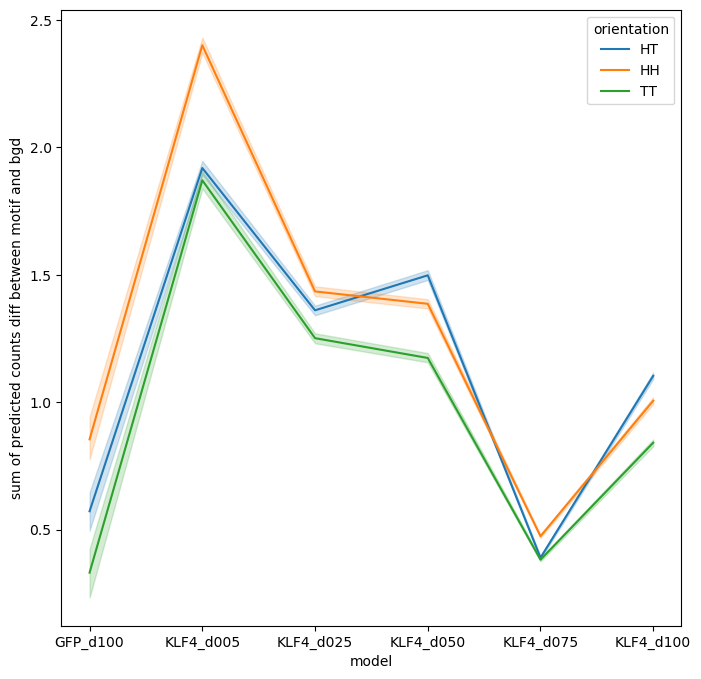

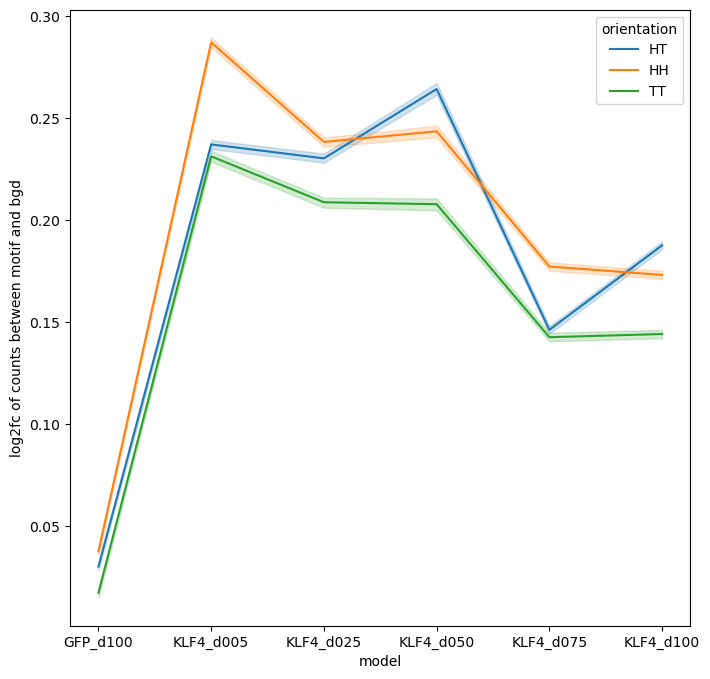

In [21]:
# this plots 1 line per param in param list, only plot for a small number of parameters
plt.figure(figsize=(8,8))
sns.lineplot(data=summary_tf, x="exp", y="sumdiff_s1", hue="orientation")
plt.xlabel("model")
plt.ylabel("sum of predicted counts diff between motif and bgd")
plt.savefig(f"{plotdir}/sumdiff_bydose_byorient_{n_bgd}bgd_{suffix}_singlebase.pdf", dpi=150)

plt.figure(figsize=(8,8))
sns.lineplot(data=summary_tf, x="exp", y="log2fc_s1", hue="orientation")
plt.xlabel("model")
plt.ylabel("log2fc of counts between motif and bgd")
plt.savefig(f"{plotdir}/log2fc_bydose_byorient_{n_bgd}bgd_{suffix}_singlebase.pdf", dpi=150)

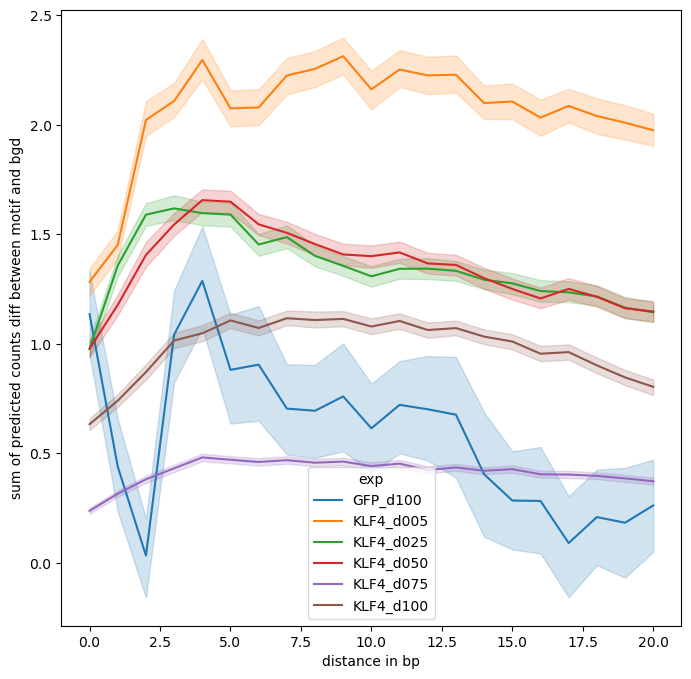

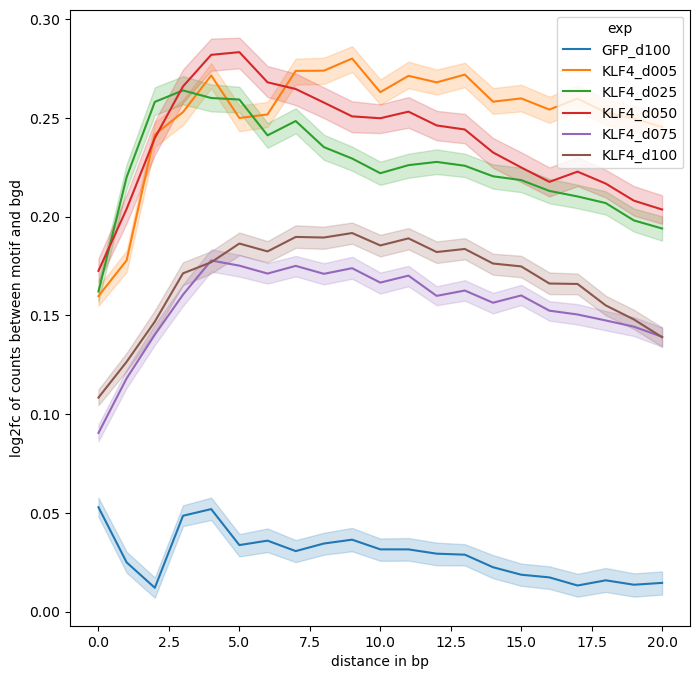

In [22]:
# spacing effects
plt.figure(figsize=(8,8))
sns.lineplot(data=summary_tf, x="spacing", y="sumdiff_s1", hue="exp")
plt.xlabel("distance in bp")
plt.ylabel("sum of predicted counts diff between motif and bgd")
plt.savefig(f"{plotdir}/sumdiff_byspacing_{n_bgd}bgd_{suffix}_singlebase.pdf", dpi=150)

plt.figure(figsize=(8,8))
sns.lineplot(data=summary_tf, x="spacing", y="log2fc_s1", hue="exp")
plt.xlabel("distance in bp")
plt.ylabel("log2fc of counts between motif and bgd")
plt.savefig(f"{plotdir}/log2fc_byspacing_{n_bgd}bgd_{suffix}_singlebase.pdf", dpi=150)

<Figure size 800x800 with 0 Axes>

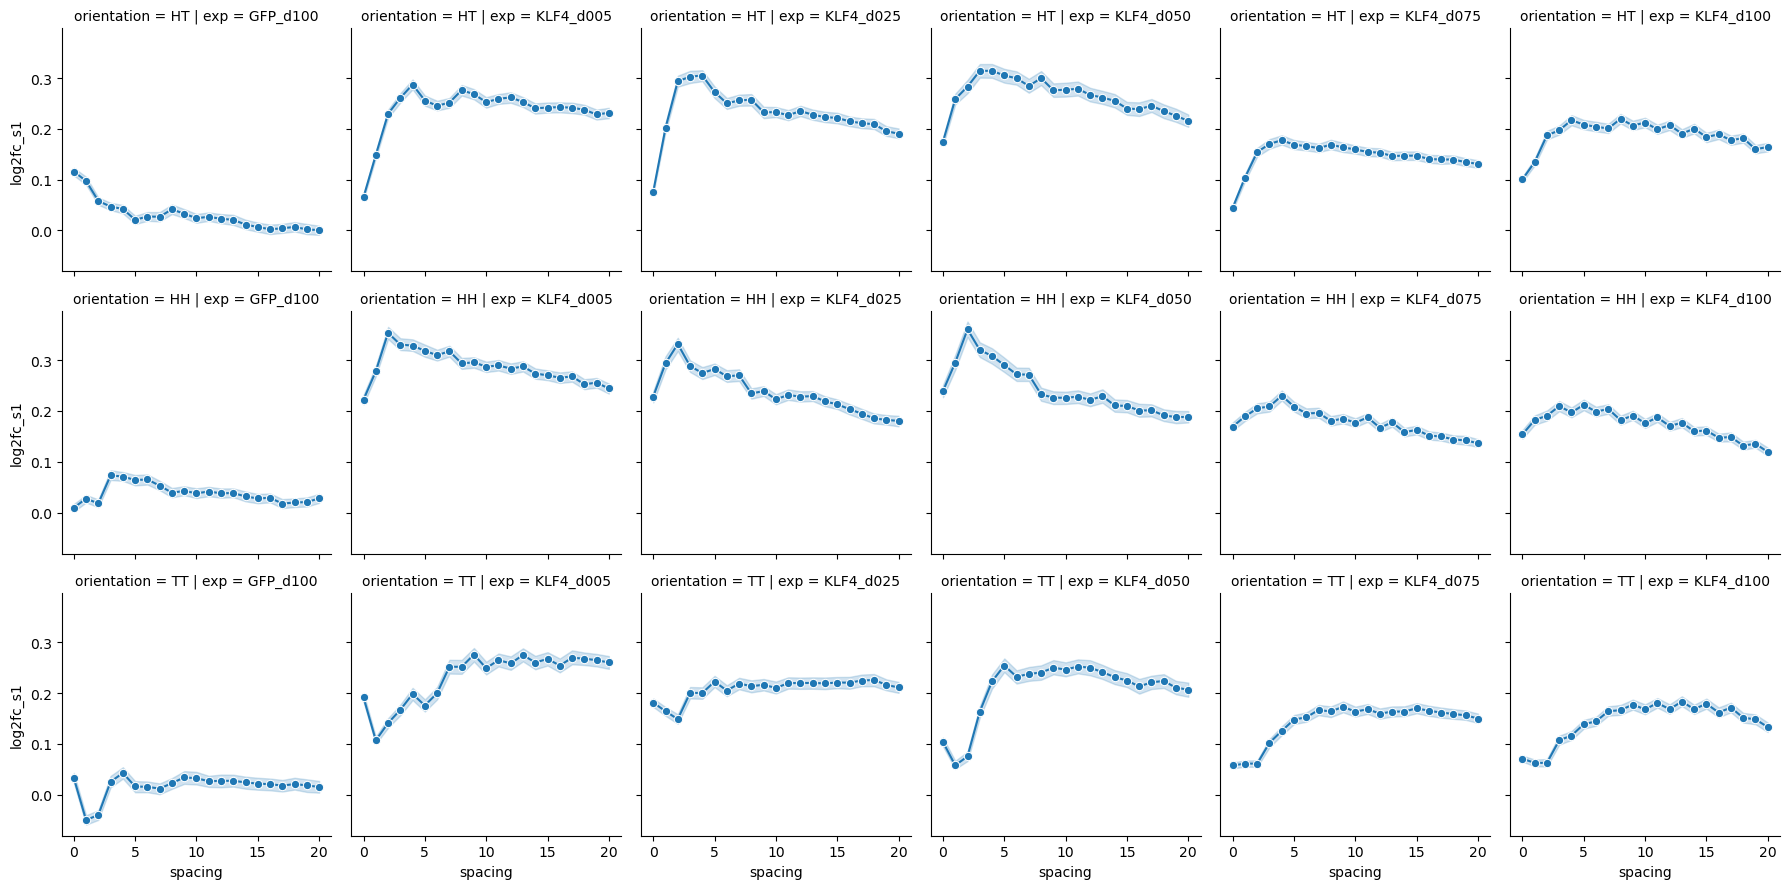

<Figure size 800x800 with 0 Axes>

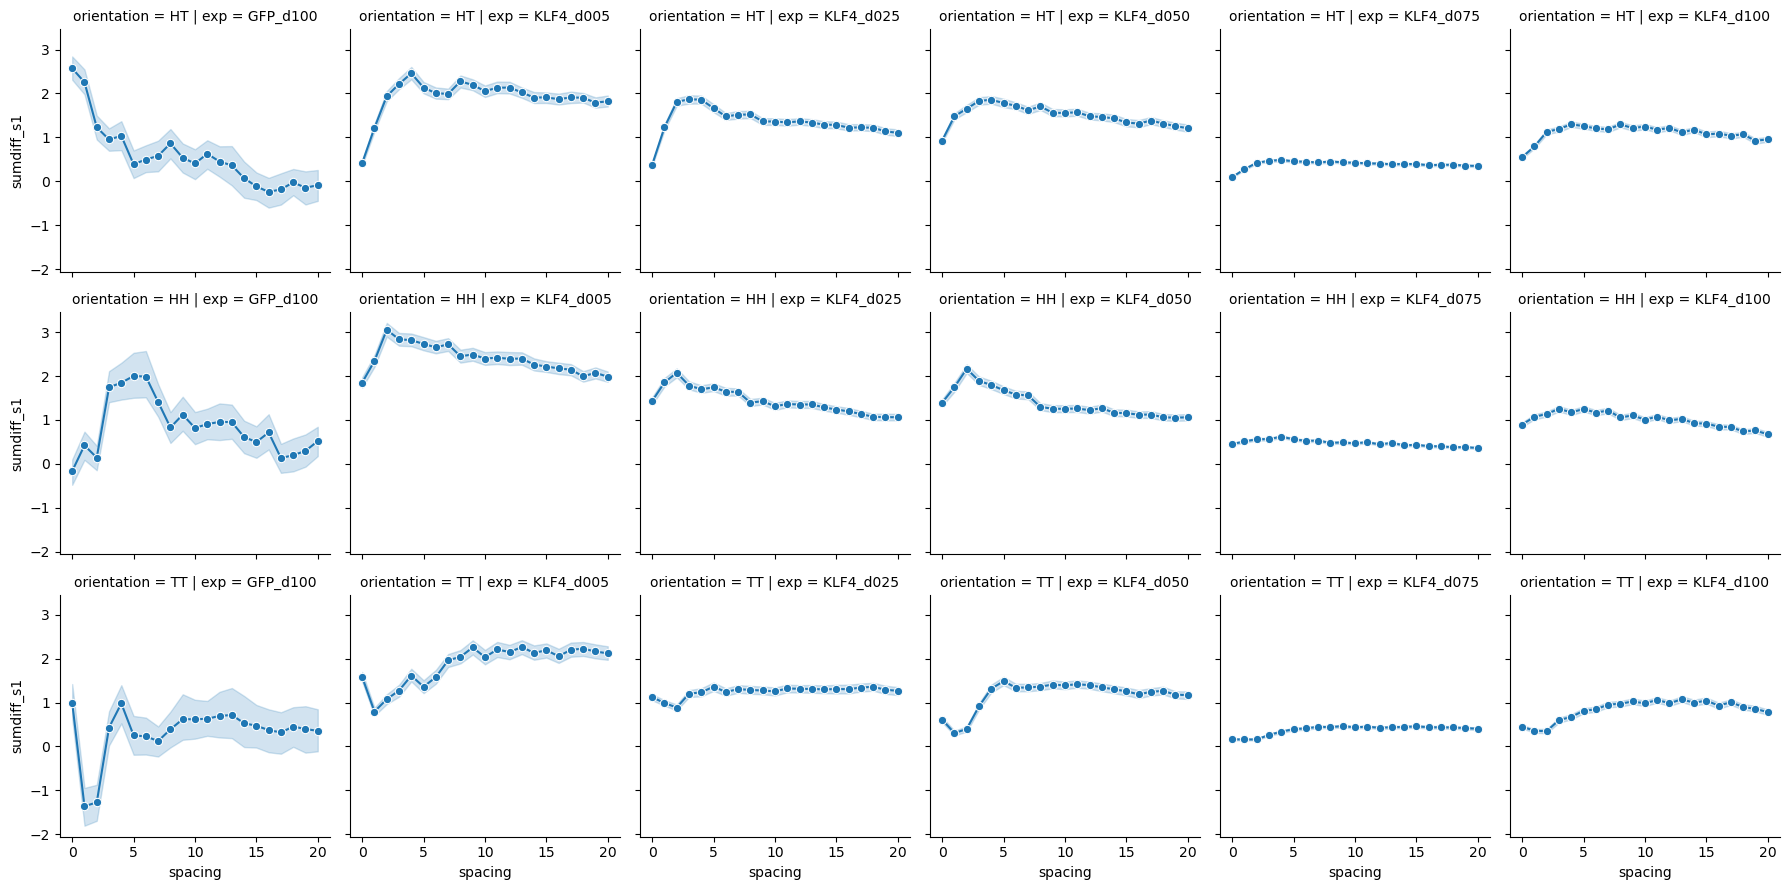

In [23]:
# spacing x orientation x dose
plt.figure(figsize=(8,8))
g = sns.FacetGrid(summary_tf, col="exp", row="orientation")
g.map(sns.lineplot, "spacing", "log2fc_s1", marker="o")
plt.savefig(f"{plotdir}/log2fc_facet_orientxexp_{n_bgd}bgd_{suffix}_singlebase.pdf", dpi=150)

plt.figure(figsize=(8,8))
g = sns.FacetGrid(summary_tf, col="exp", row="orientation")
g.map(sns.lineplot, "spacing", "sumdiff_s1", marker="o")
plt.savefig(f"{plotdir}/sumdiff_facet_orientxexp_{n_bgd}bgd_{suffix}_singlebase.pdf", dpi=150)


### Autocorrelate the spacing plot to detect periodicity

In [36]:
summary_tf

bgd        exp sumdiff_s1 log2fc_s1 sumdiff_s2 log2fc_s2 sumdiff_s3  \
0      0   GFP_d100   2.780612  0.129703   2.780612  3.163707   2.431346   
1      1   GFP_d100   1.921501  0.113461   1.921501  2.558466   1.528621   
2      2   GFP_d100   1.987221  0.145949   1.987221  1.063061   0.163012   
3      3   GFP_d100   1.266445  0.057517   1.266445       NaN   1.639884   
4      4   GFP_d100    0.32856  0.038294    0.32856  5.343793   0.320265   
..   ...        ...        ...       ...        ...       ...        ...   
995  995  KLF4_d100   0.732347  0.133608   0.732347  1.774187   0.429781   
996  996  KLF4_d100   1.316496  0.216725   1.316496  1.382387   0.497267   
997  997  KLF4_d100   0.080554  0.020692   0.080554 -0.475927    0.36723   
998  998  KLF4_d100   2.349736  0.308399   2.349736  1.726772   1.332475   
999  999  KLF4_d100  -0.341222 -0.068076  -0.341222 -0.729324  -1.201125   

    log2fc_s3 sumdiff_s4 log2fc_s4 sumdiff_s5 log2fc_s5  \
0    4.163707   3.129878  0.146851 -26.778797 -0.870297   
1    3.558466   2.314381  0.137801 -21.562773 -0.886539   
2    2.063061   3.811429  0.294311 -16.679416 -0.854051   
3         NaN   0.893006  0.040317 -29.870974 -0.942483   
4    6.343793   0.336854  0.039274 -11.886229 -0.961706   
..        ...        ...       ...        ...       ...   
995  2.774187   1.034914  0.192635  -6.815019 -0.866392   
996  2.382387   2.135726  0.370118  -6.805403 -0.783275   
997  0.524073  -0.206121 -0.051632  -5.495828 -0.979308   
998  2.726772   3.366997   0.46551  -7.509316 -0.691601   
999  0.270676   0.518682  0.110054  -7.744466 -1.068076   

                      name  spacing orientation  dose  
0     KLF4_CCCCACCC_HT_0bp        0          HT  d000  
1     KLF4_CCCCACCC_HT_0bp        0          HT  d000  
2     KLF4_CCCCACCC_HT_0bp        0          HT  d000  
3     KLF4_CCCCACCC_HT_0bp        0          HT  d000  
4     KLF4_CCCCACCC_HT_0bp        0          HT  d000  
..                     ...      ...         ...   ...  
995  KLF4_CCCCACCC_TT_20bp       20          TT  d100  
996  KLF4_CCCCACCC_TT_20bp       20          TT  d100  
997  KLF4_CCCCACCC_TT_20bp       20          TT  d100  
998  KLF4_CCCCACCC_TT_20bp       20          TT  d100  
999  KLF4_CCCCACCC_TT_20bp       20          TT  d100  

[378000 rows x 16 columns]

In [39]:
summary_tf.loc[summary_tf.exp==exp].groupby(["orientation", "spacing"]).log2fc_s1.mean().shape

(63,)

<Figure size 800x800 with 0 Axes>

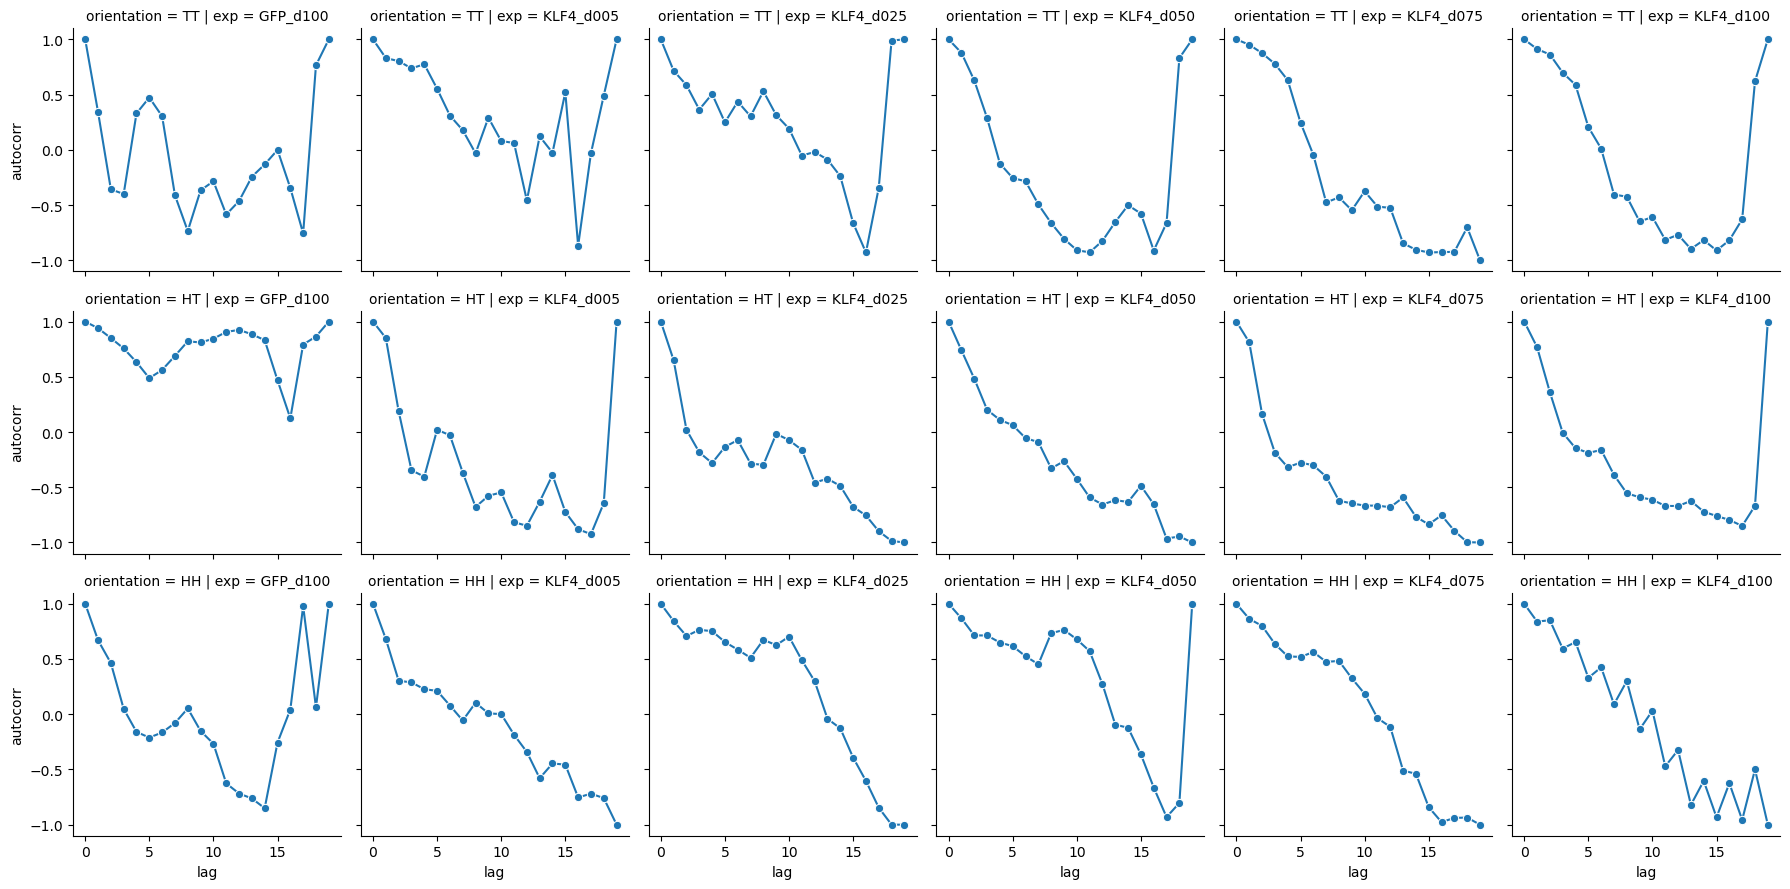

In [41]:
autocorrs = []
for exp in exp_ls:
    for orient in set(summary_tf.orientation):
        log2fc = summary_tf.loc[(summary_tf.exp==exp)&(summary_tf.orientation==orient)].groupby("spacing").log2fc_s1.mean()
        n = log2fc.shape[0]
        autocorrs.append(pd.DataFrame([autocorr(list(log2fc)), [exp]*n, list(range(n)),[orient]*n], index=["autocorr", "exp", "lag", "orientation"]).transpose())
autocorrs = pd.concat(autocorrs, axis=0).reset_index()

plt.figure(figsize=(8,8))
g = sns.FacetGrid(autocorrs, col="exp", row="orientation")
g.map(sns.lineplot, "lag", "autocorr", marker="o")
plt.savefig(f"{plotdir}/autocorr_log2fc_facet_orientxexp_{n_bgd}bgd_{suffix}_singlebase.pdf", dpi=150)

### boxplots

Text(0, 0.5, 'log2fc of counts between homocomposite motif and single motif')

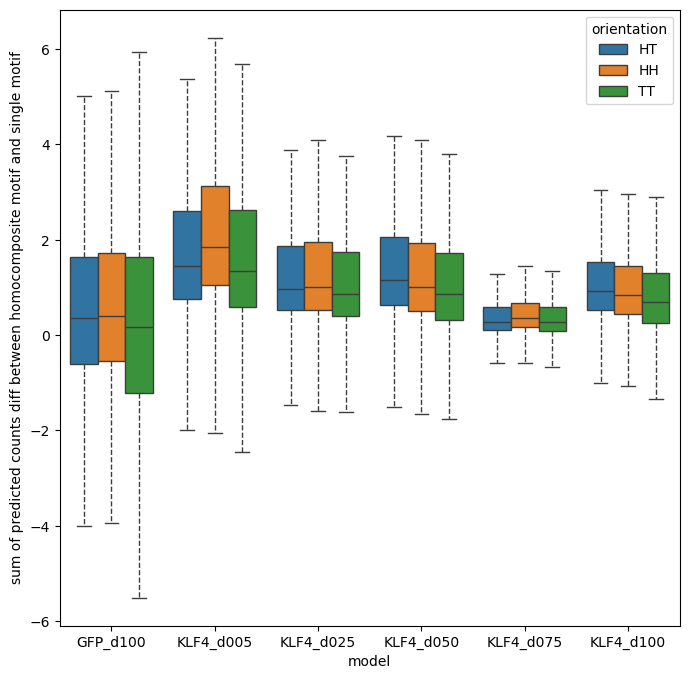

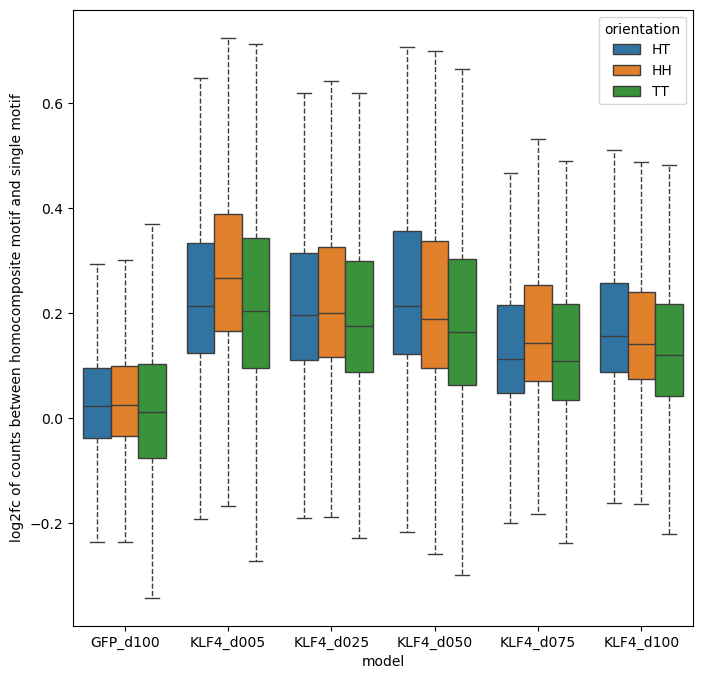

In [43]:
plt.figure(figsize=(8,8))
sns.boxplot(data=summary_tf, x="exp", y="sumdiff_s1", hue="orientation", showfliers=False)
for i in range(1,len(plt.gca().lines),5):
    plt.gca().lines[i].set_linestyle('--')  # upper whisker
for i in range(0,len(plt.gca().lines),5):
    plt.gca().lines[i].set_linestyle('--')  # Lower whisker
plt.xlabel("model")
plt.ylabel("sum of predicted counts diff between homocomposite motif and single motif")
# plt.savefig(f"{plotdir}/boxplot_sumdiff_HH_HT_TT_bymodel_singlebase_{suffix}.pdf", dpi=150)

plt.figure(figsize=(8,8))
sns.boxplot(data=summary_tf, x="exp", y="log2fc_s1", hue="orientation", showfliers=False)
for i in range(1,len(plt.gca().lines),5):
    plt.gca().lines[i].set_linestyle('--')  # upper whisker
for i in range(0,len(plt.gca().lines),5):
    plt.gca().lines[i].set_linestyle('--')  # Lower whisker
plt.xlabel("model")
plt.ylabel("log2fc of counts between homocomposite motif and single motif")
# plt.savefig(f"{plotdir}/lineplots/boxplot_log2fc_HH_HT_TT_bymodel_singlebase_{suffix}.pdf", dpi=150)

In [47]:
# calculate the p values between different orientations
from scipy import stats

output = []
for currexp in exp_ls:
    print(currexp)
    toplot = summary_tf[summary_tf.exp==currexp]
    for m1 in set(summary_tf.orientation):
        for m2 in set(summary_tf.orientation):
            if m1 != m2:
                res1 = stats.wilcoxon(toplot.loc[toplot.orientation==m1, "log2fc_s1"], 
                                    toplot.loc[toplot.orientation==m2, "log2fc_s1"])      
                res2 = stats.ttest_rel(toplot.loc[toplot.orientation==m1, "log2fc_s1"], 
                                    toplot.loc[toplot.orientation==m2, "log2fc_s1"])  

                print(f"{m1} vs {m2}: Wilcoxon p={res1.pvalue:.3f}, paired t p={res2.pvalue:.3f}")
                output.append(pd.DataFrame([m1, m2, res1.pvalue, res2.pvalue, currexp], index=["s1", "s2", "wilcoxon.p", "pairedttest.p", "model"]).transpose())
output = pd.concat(output, axis=0)
output.head()

GFP_d100
TT vs HT: Wilcoxon p=0.000, paired t p=0.000
TT vs HH: Wilcoxon p=0.000, paired t p=0.000
HT vs TT: Wilcoxon p=0.000, paired t p=0.000
HT vs HH: Wilcoxon p=0.000, paired t p=0.000
HH vs TT: Wilcoxon p=0.000, paired t p=0.000
HH vs HT: Wilcoxon p=0.000, paired t p=0.000
KLF4_d005
TT vs HT: Wilcoxon p=0.000, paired t p=0.000
TT vs HH: Wilcoxon p=0.000, paired t p=0.000
HT vs TT: Wilcoxon p=0.000, paired t p=0.000
HT vs HH: Wilcoxon p=0.000, paired t p=0.000
HH vs TT: Wilcoxon p=0.000, paired t p=0.000
HH vs HT: Wilcoxon p=0.000, paired t p=0.000
KLF4_d025
TT vs HT: Wilcoxon p=0.000, paired t p=0.000
TT vs HH: Wilcoxon p=0.000, paired t p=0.000
HT vs TT: Wilcoxon p=0.000, paired t p=0.000
HT vs HH: Wilcoxon p=0.000, paired t p=0.000
HH vs TT: Wilcoxon p=0.000, paired t p=0.000
HH vs HT: Wilcoxon p=0.000, paired t p=0.000
KLF4_d050
TT vs HT: Wilcoxon p=0.000, paired t p=0.000
TT vs HH: Wilcoxon p=0.000, paired t p=0.000
HT vs TT: Wilcoxon p=0.000, paired t p=0.000
HT vs HH: Wilcox

s1  s2 wilcoxon.p pairedttest.p     model
0  TT  HT        0.0           0.0  GFP_d100
0  TT  HH        0.0           0.0  GFP_d100
0  HT  TT        0.0           0.0  GFP_d100
0  HT  HH        0.0           0.0  GFP_d100
0  HH  TT        0.0           0.0  GFP_d100

## plot orientation and spacing effects, all TFs

### get all data

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
summary_all = []
# for TF in ["ELF1", "SPI1"]:
for TF in core_motif_dict.keys():
    print(TF)
    exp_ls = ["GFP_d100", f"{TF}_d005", f"{TF}_d025", f"{TF}_d050", f"{TF}_d075", f"{TF}_d100"]
    outdir = f"{base_dir}/output/02-atac/14/HEK293T_{TF}/marginalize/homocomposite/"
    plotdir = f"{base_dir}/plots/02-atac/14/HEK293T_{TF}/marginalize/homocomposite/"
    core_seq = core_motif_dict[TF]

    # take the difference between single core motif and homocomposite motif predicted counts for each model
    # first entry of params must be the single core motif
    params = [f"{TF}_{core_seq}"] +\
            [f"{TF}_{core_seq}_{dir}_{i}bp" for i in range(0,21) for dir in ["HT", "HH", "TT"]]

    # load control 
    name = params[0]
    counts_ctl = pd.read_csv(f"{outdir}/insert_{name}_{n_bgd}bgd.csv", sep=",")
    logits_ctl = pd.read_csv(f"{outdir}/insert_{name}_{n_bgd}bgd_avglogits.csv", sep=",")

    summary_tf = []
    for k in range(1,len(params)):
        name = params[k]
        counts = pd.read_csv(f"{outdir}/insert_{name}_{n_bgd}bgd.csv", sep=",")
        logits = pd.read_csv(f"{outdir}/insert_{name}_{n_bgd}bgd_avglogits.csv", sep=",")

        for i in range(len(exp_ls)):
            n = exp_ls[i]
            avg_counts_base = np.exp(counts_ctl[f"synth_pred_counts_{n}"])
            avg_counts_synth = np.exp(counts[f"synth_pred_counts_{n}"])
            avg_counts_null = np.exp(counts[f"base_pred_counts_{n}"])
            
            # stat 1: single motif as denominator, log2fc = inserted motif / single motif 
            sumdiff_s1 = avg_counts_synth - avg_counts_base
            log2fc_s1 = np.log2((avg_counts_synth/avg_counts_base))

            # stat 2: (single motif - no insertion) as denominator, log2fc = (inserted motif - no insertion) / (single motif - no insertion)
            sumdiff_s2 = sumdiff_s1
            log2fc_s2 = np.log2((avg_counts_synth - avg_counts_null)/(avg_counts_base - avg_counts_null))

            # stat 3: (single motif - no insertion)*2 as denominator, log2fc = (inserted motif - no insertion) / (single motif - no insertion)*2 [cooperativity]
            sumdiff_s3 = (avg_counts_synth - avg_counts_null) - (avg_counts_base - avg_counts_null)*2
            log2fc_s3 = np.log2((avg_counts_synth - avg_counts_null)/(avg_counts_base - avg_counts_null)*2)

            # stat 4: null as denominator, log2fc = inserted motif / no insertion
            sumdiff_s4 = avg_counts_synth - avg_counts_null
            log2fc_s4 = np.log2((avg_counts_synth/avg_counts_null))

            # stat 5: single motif*2 as denominator, log2fc = inserted motif / single motif*2 [cooperativity]
            sumdiff_s5 = avg_counts_synth  - avg_counts_base*2
            log2fc_s5 = np.log2(avg_counts_synth /(avg_counts_base*2))


            l = len(log2fc_s1)
            summary_tf.append(pd.DataFrame([list(range(l)), [n]*l, sumdiff_s1, log2fc_s1, sumdiff_s2, log2fc_s2, sumdiff_s3, log2fc_s3, sumdiff_s4, log2fc_s4, sumdiff_s5, log2fc_s5, [name]*l], 
                                            index=["bgd", "exp", "sumdiff_s1", "log2fc_s1", "sumdiff_s2", "log2fc_s2", "sumdiff_s3", "log2fc_s3", "sumdiff_s4", "log2fc_s4", "sumdiff_s5", "log2fc_s5","name"]).transpose())

    summary_tf = pd.concat(summary_tf, axis=0)
    summary_tf["TF"] = TF
    summary_all.append(summary_tf)

summary_all = pd.concat(summary_all, axis=0)

SPI1
ELF1
KLF1
KLF4
ALX4
SP4
IRF4
LEF1
OCT4
SOX2
TCF3


In [7]:
summary_all["spacing"] = np.array([int(n.split("_")[-1].split("bp")[0]) for n in list(summary_all.name)])
summary_all["orientation"] = [n.split("_")[-2] for n in list(summary_all.name)]
summary_all["dose"] = [n.split("_")[-1] for n in list(summary_all.exp)]
summary_all.loc[summary_all.exp=="GFP_d100", "dose"] = "d000"

print(summary_all.shape)
print(summary_all.head(10))

(4158000, 17)
  bgd       exp sumdiff_s1 log2fc_s1 sumdiff_s2 log2fc_s2 sumdiff_s3  \
0   0  GFP_d100   0.022509  0.001053   0.022509  0.019996  -1.590294   
1   1  GFP_d100  -0.111018 -0.006995  -0.111018  0.840601    0.02937   
2   2  GFP_d100  -0.313307 -0.024239  -0.313307 -0.250908  -2.275986   
3   3  GFP_d100  -0.001775 -0.000082  -0.001775  0.025617   0.097291   
4   4  GFP_d100  -0.173035 -0.020297  -0.173035 -4.873331  -0.352182   
5   5  GFP_d100  -0.285668 -0.019023  -0.285668 -1.423092  -0.741214   
6   6  GFP_d100   -5.94781 -0.198236   -5.94781       NaN  -8.885201   
7   7  GFP_d100   0.381299  0.024473   0.381299 -1.302236   1.022673   
8   8  GFP_d100  -1.300019 -0.062236  -1.300019       NaN  -2.397873   
9   9  GFP_d100  -0.021252 -0.002065  -0.021252  0.178842   0.139781   

  log2fc_s3 sumdiff_s4 log2fc_s4 sumdiff_s5 log2fc_s5              name    TF  \
0  1.019996   1.635312  0.078589 -30.800437 -0.998947  SPI1_GGAA_HT_0bp  SPI1   
1  1.840601  -0.251405 -0.01579

log2fc_s1


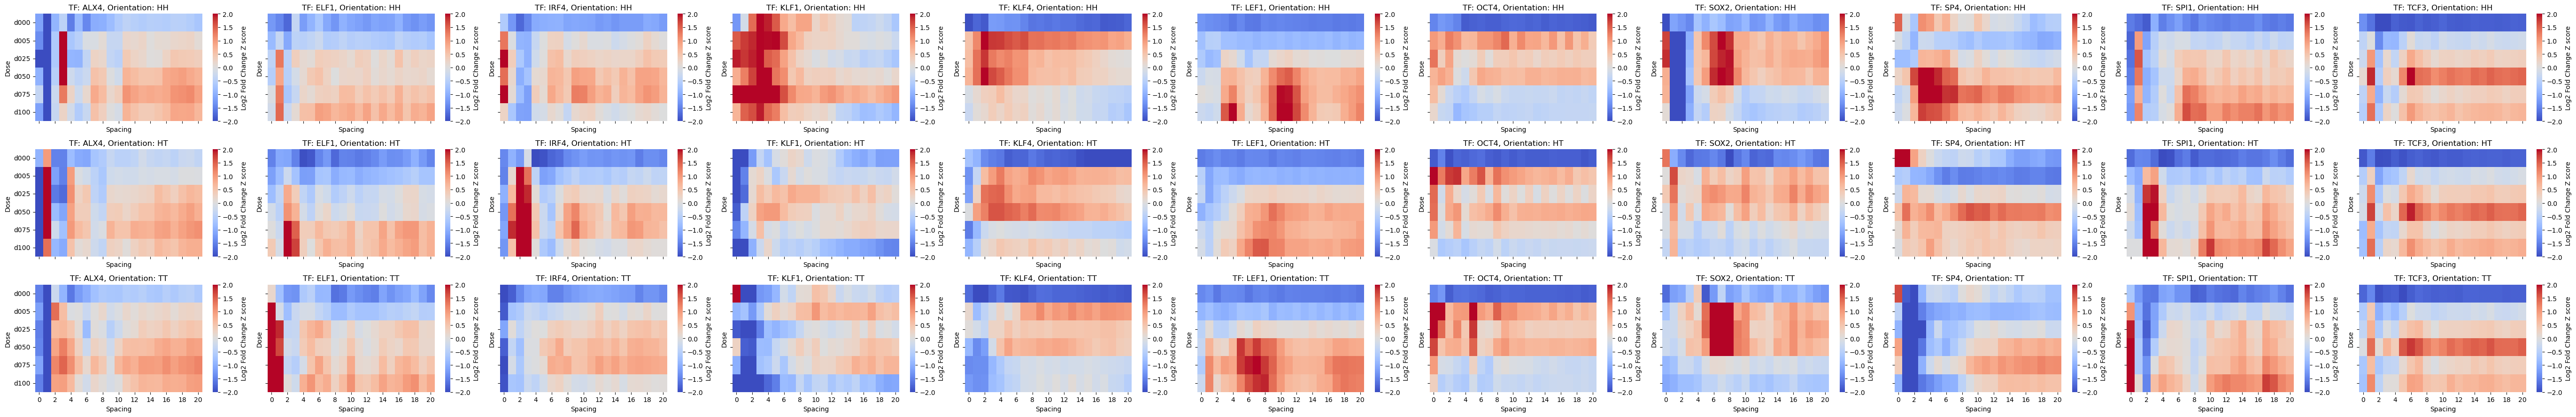

sumdiff_s2


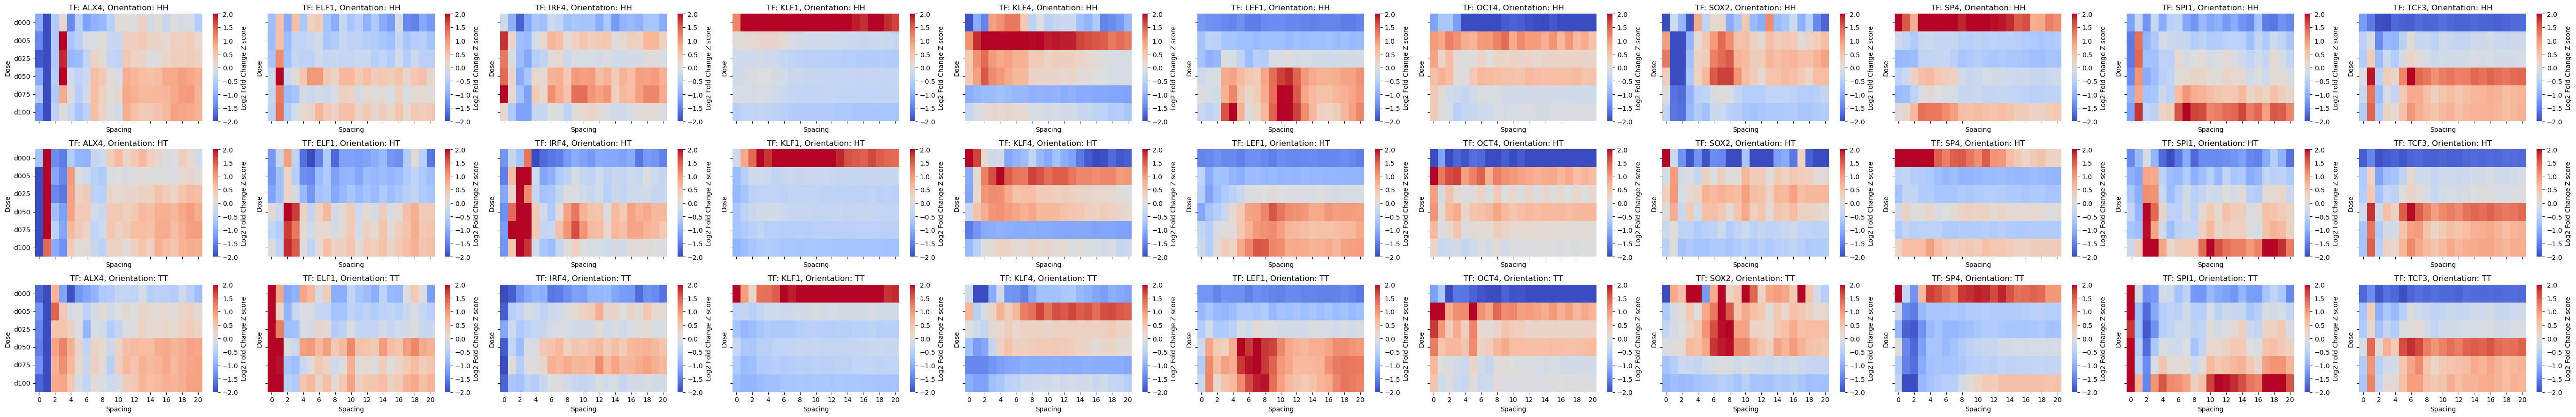

sumdiff_s3


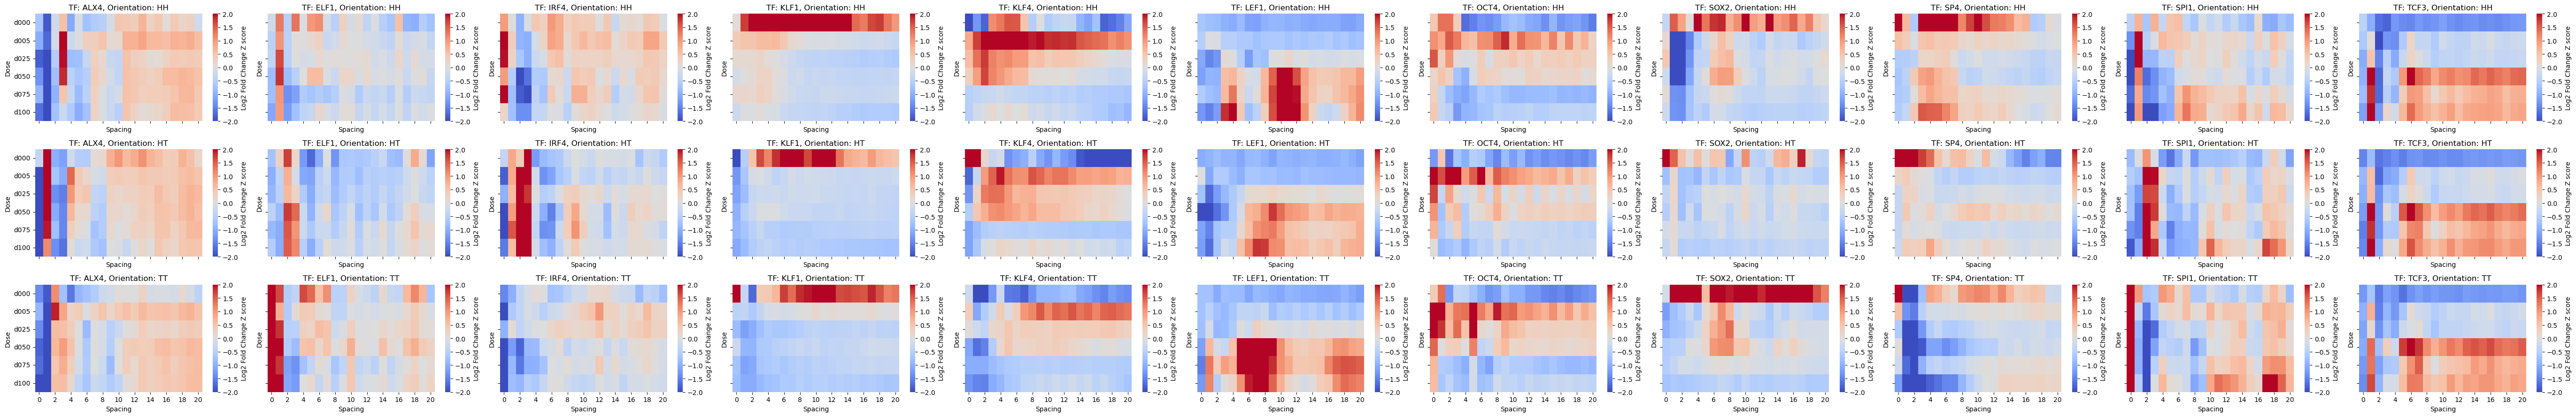

log2fc_s4


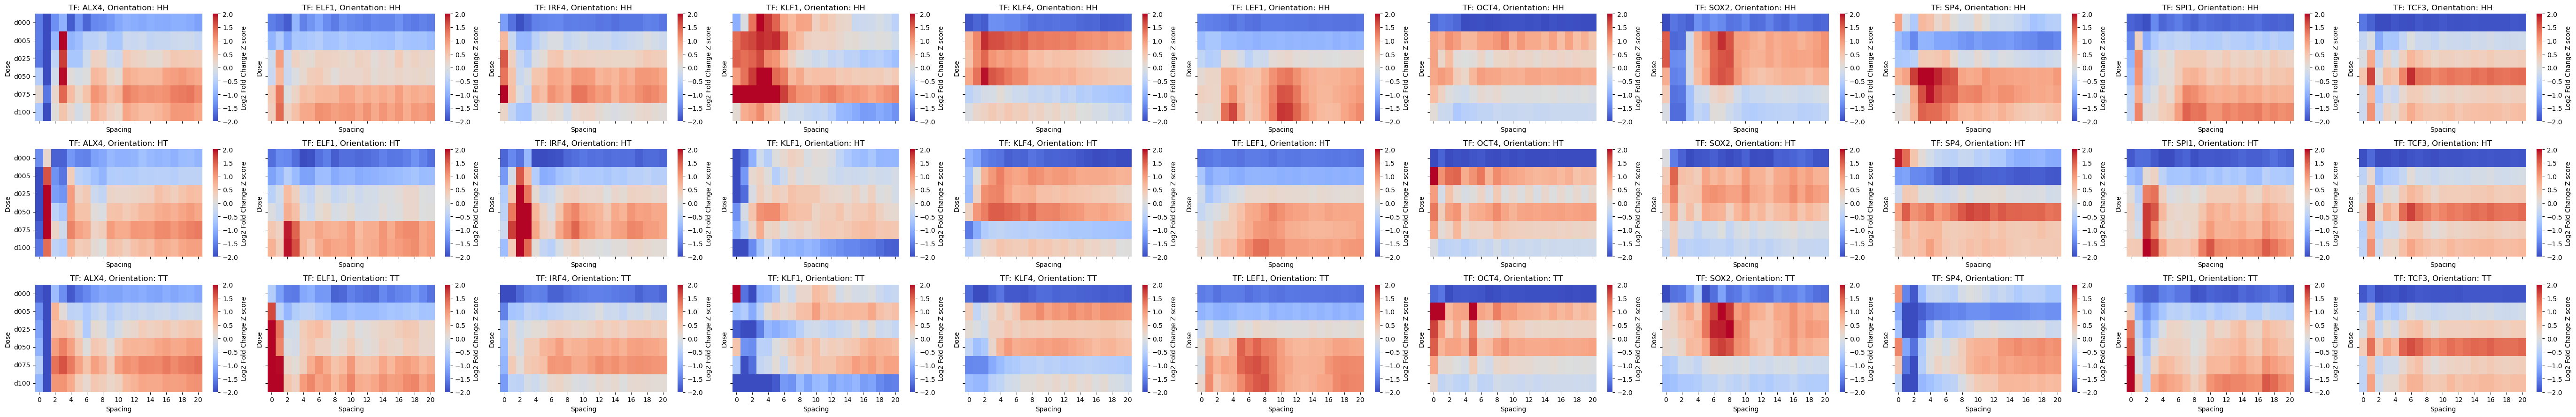

log2fc_s5


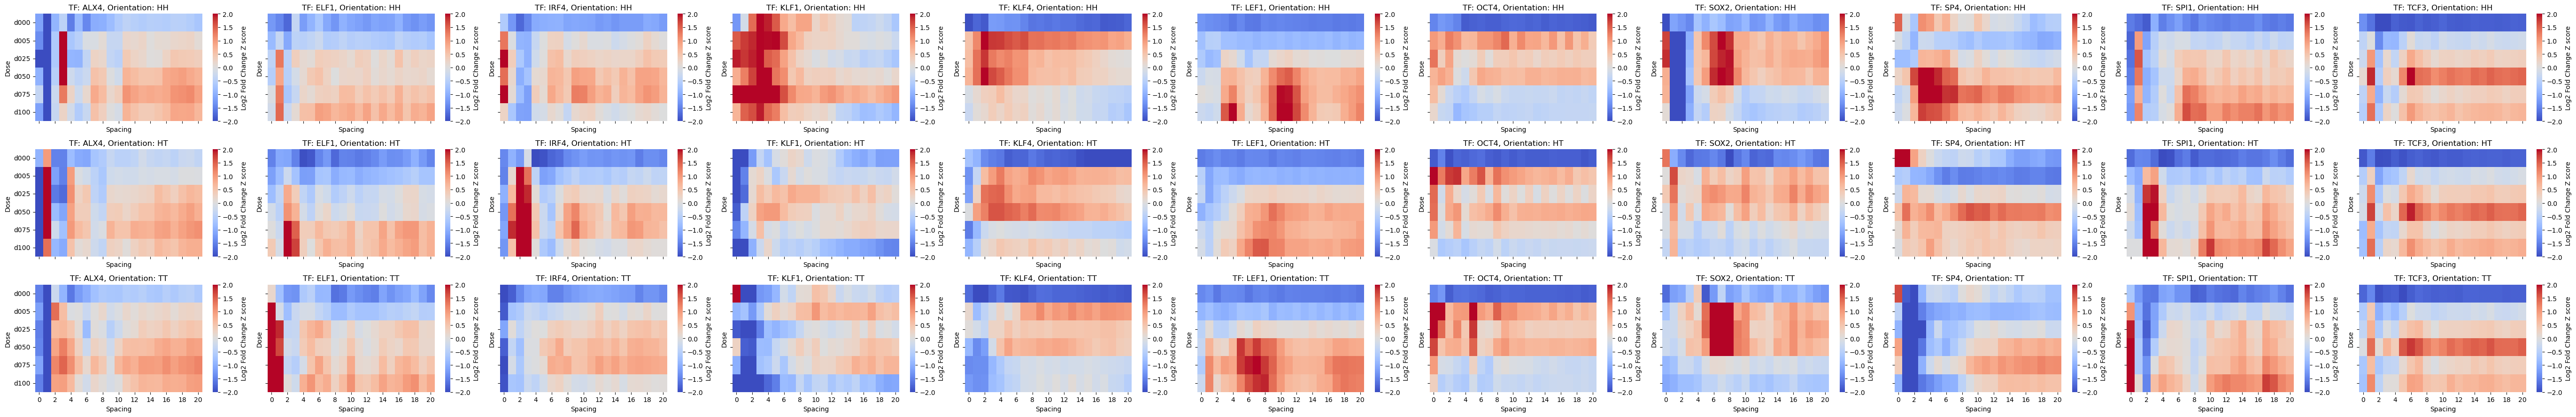

In [ ]:
from scipy.stats import zscore
def zscore_omitnan(data):
    return zscore(data, nan_policy='omit')

for stat in ["log2fc_s1", "sumdiff_s2", "sumdiff_s3", "log2fc_s4", "log2fc_s5"]:
    print(stat)
    grouped_df = summary_all.groupby(['TF', 'spacing', 'orientation', 'dose'])[stat].mean().reset_index()
    grouped_df['zscore'] = grouped_df.groupby(['TF'])[stat].transform(zscore_omitnan)
    unique_doses = grouped_df['dose'].unique()
    unique_orientations = grouped_df['orientation'].unique()
    unique_tfs = sorted(grouped_df['TF'].unique())

    n_tf = len(unique_tfs)
    n_dose = len(unique_doses)
    n_orientation = len(unique_orientations)

    fig, axes = plt.subplots(n_orientation, n_tf, figsize=(5 * n_tf, 3 * n_orientation), sharex=True, sharey=True)

    for i, orientation in enumerate(unique_orientations):
        for j, tf in enumerate(unique_tfs):
            # Filter data for the current exp and orientation
            data_subset = grouped_df[(grouped_df['TF'] == tf) & (grouped_df['orientation'] == orientation)]
            
            # Pivot the data for the heatmap
            heatmap_data = data_subset.pivot_table(index='dose', columns='spacing', values='zscore')

            # Create the heatmap
            sns.heatmap(heatmap_data, annot=False, cmap='coolwarm', cbar_kws={'label': 'Log2 Fold Change Z score'}, ax=axes[i, j], vmin=-2, vmax=2)
            
            # Set titles
            axes[i, j].set_title(f'TF: {tf}, Orientation: {orientation}')
            axes[i, j].set_xlabel('Spacing')
            axes[i, j].set_ylabel('Dose')

    # Adjust layout
    plt.tight_layout()
    plt.savefig(f"{base_dir}/plots/02-atac/14/heatmap_all_tf_{stat}_zscore_perTF.pdf")
    plt.show()

## compare two core motifs for the same TF

In [9]:
TF = "KLF1"
core_motif_list = ["CCCCGCCCC", "CCACGCCCA"]

In [ ]:
outdir = f"{base_dir}/output/02-atac/14/HEK293T_{TF}/marginalize/homocomposite/"
plotdir = f"{base_dir}/plots/02-atac/14/HEK293T_{TF}/marginalize/compare_core_motifs/"
os.makedirs(outdir, exist_ok=True)
os.makedirs(plotdir, exist_ok=True)

exp_ls = ["GFP_d100", f"{TF}_d005", f"{TF}_d025", f"{TF}_d050", f"{TF}_d075", f"{TF}_d100"]

params = [f"{TF}_{core_seq}" for core_seq in core_motif_list]
print(params)

['KLF1_CCCCGCCCC', 'KLF1_CCACGCCCA']


In [21]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# load control 
name = params[0]
counts_ctl = pd.read_csv(f"{outdir}/insert_{name}_{n_bgd}bgd.csv", sep=",")
logits_ctl = pd.read_csv(f"{outdir}/insert_{name}_{n_bgd}bgd_avglogits.csv", sep=",")

summary_tf = []
for k in range(len(params)):
    name = params[k]
    counts = pd.read_csv(f"{outdir}/insert_{name}_{n_bgd}bgd.csv", sep=",")
    logits = pd.read_csv(f"{outdir}/insert_{name}_{n_bgd}bgd_avglogits.csv", sep=",")

    for i in range(len(exp_ls)):
        n = exp_ls[i]
        avg_counts_base = np.exp(counts_ctl[f"synth_pred_counts_{n}"])
        avg_counts_synth = np.exp(counts[f"synth_pred_counts_{n}"])
        avg_counts_null = np.exp(counts[f"base_pred_counts_{n}"])
        
        # stat 1: first motif as denominator, log2fc = inserted motif / first motif 
        sumdiff_s1 = avg_counts_synth - avg_counts_base
        log2fc_s1 = np.log2((avg_counts_synth/avg_counts_base))

        # stat 2: null as denominator, log2fc = inserted motif / no insertion
        sumdiff_s2 = avg_counts_synth - avg_counts_null
        log2fc_s2 = np.log2((avg_counts_synth/avg_counts_null))

        l = len(log2fc_s1)
        summary_tf.append(pd.DataFrame([list(range(l)), [n]*l, sumdiff_s1, log2fc_s1, sumdiff_s2, log2fc_s2, avg_counts_base, avg_counts_synth, avg_counts_null, [name]*l], 
                                        index=["bgd", "exp", "sumdiff_s1", "log2fc_s1", "sumdiff_s2", "log2fc_s2", f"counts_base", f"counts_synth", f"counts_null", "name"]).transpose())

summary_tf = pd.concat(summary_tf, axis=0)

In [22]:
summary_tf["dose"] = [n.split("_")[-1] for n in list(summary_tf.exp)]
summary_tf.loc[summary_tf.exp=="GFP_d100", "dose"] = "d000"

print(summary_tf.shape)
print(summary_tf.head(10))

(12000, 11)
  bgd       exp sumdiff_s1 log2fc_s1 sumdiff_s2 log2fc_s2 counts_base  \
0   0  GFP_d100        0.0       0.0   2.639578  0.124811    31.84972   
1   1  GFP_d100        0.0       0.0   4.081214  0.234798   27.172608   
2   2  GFP_d100        0.0       0.0   3.495062  0.272042    20.33749   
3   3  GFP_d100        0.0       0.0   0.642278   0.02911   32.153136   
4   4  GFP_d100        0.0       0.0   0.060544  0.007138   12.267038   
5   5  GFP_d100        0.0       0.0   4.740963  0.289279   26.093851   
6   6  GFP_d100        0.0       0.0   1.640609  0.053543   45.031286   
7   7  GFP_d100        0.0       0.0   4.749886  0.271611   27.679005   
8   8  GFP_d100        0.0       0.0   4.370441  0.198105   34.062855   
9   9  GFP_d100        0.0       0.0   0.527518  0.049807   15.545335   

  counts_synth counts_null            name  dose  
0     31.84972   29.210143  KLF1_CCCCGCCCC  d000  
1    27.172608   23.091394  KLF1_CCCCGCCCC  d000  
2     20.33749   16.842428  KLF

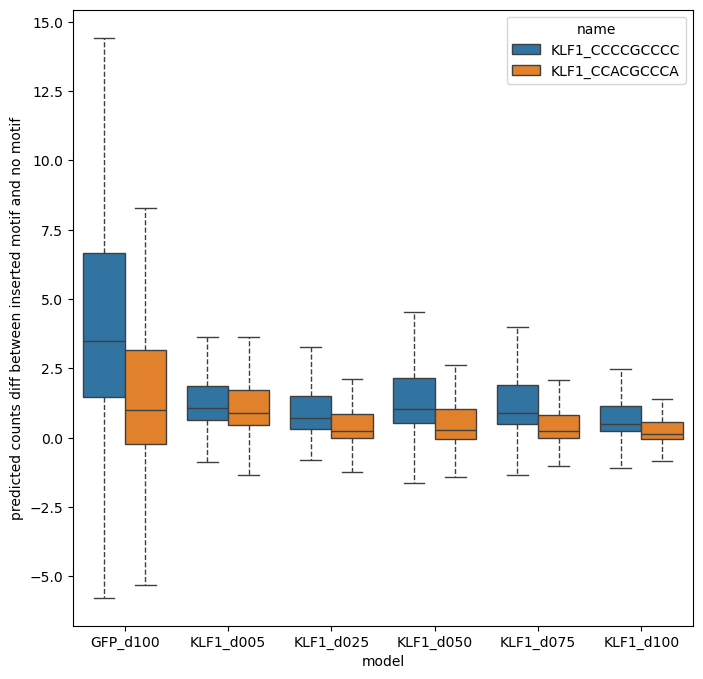

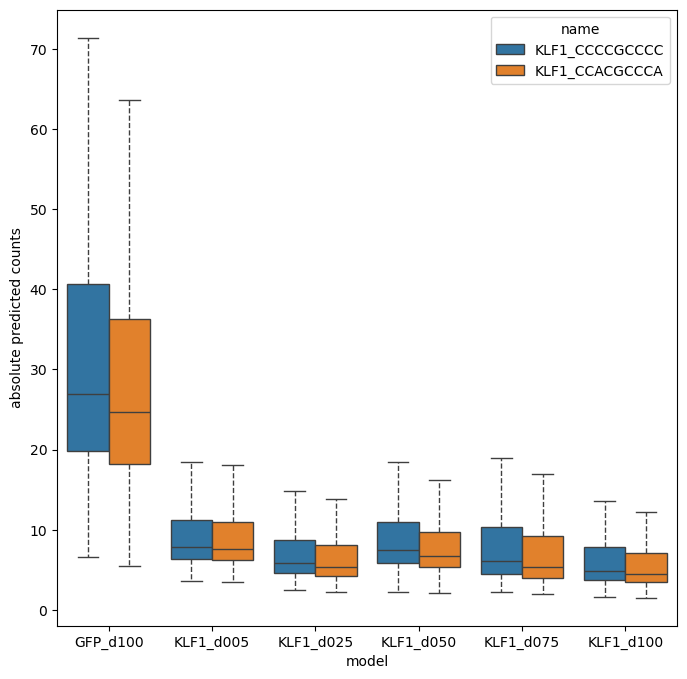

In [30]:
plt.figure(figsize=(8,8))
sns.boxplot(data=summary_tf, x="exp", y="sumdiff_s2", hue="name", showfliers=False)
for i in range(1,len(plt.gca().lines),5):
    plt.gca().lines[i].set_linestyle('--')  # upper whisker
for i in range(0,len(plt.gca().lines),5):
    plt.gca().lines[i].set_linestyle('--')  # Lower whisker
plt.xlabel("model")
plt.ylabel("predicted counts diff between inserted motif and no motif")
plt.savefig(f"{plotdir}/boxplot_diff_insertedvsnull_bymodel_KLF1_core_motifs.pdf", dpi=150)

plt.figure(figsize=(8,8))
sns.boxplot(data=summary_tf, x="exp", y="counts_synth", hue="name", showfliers=False)
for i in range(1,len(plt.gca().lines),5):
    plt.gca().lines[i].set_linestyle('--')  # upper whisker
for i in range(0,len(plt.gca().lines),5):
    plt.gca().lines[i].set_linestyle('--')  # Lower whisker
plt.xlabel("model")
plt.ylabel("absolute predicted counts")
plt.savefig(f"{plotdir}/boxplot_abs_inserted_KLF1_core_motifs.pdf", dpi=150)

## plot flank effects

In [9]:
TF = "ALX4"
suffix = ""

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
nucleo = ["A", "T", "C", "G"]

summary_all = []

print(TF)
exp_ls = ["GFP_d100", f"{TF}_d005", f"{TF}_d025", f"{TF}_d050", f"{TF}_d075", f"{TF}_d100"]
outdir = f"{base_dir}/output/02-atac/14/HEK293T_{TF}/marginalize/flanks/"
plotdir = f"{base_dir}/plots/02-atac/14/HEK293T_{TF}/marginalize/flanks/"
core_seq = core_motif_dict[TF]

# first entry of params must be the single core motif
params = [f"{TF}_{core_seq}"] +\
        [f"{TF}_{core_seq}_flank_left_{i}bp_{j}" for i in range(1,21) for j in nucleo] +\
        [f"{TF}_{core_seq}_flank_right_{i}bp_{j}" for i in range(1,21) for j in nucleo]

# load control 
name = params[0]
counts_ctl = pd.read_csv(f"{outdir}/insert_{name}_{n_bgd}bgd.csv", sep=",")
logits_ctl = pd.read_csv(f"{outdir}/insert_{name}_{n_bgd}bgd_avglogits.csv", sep=",")

summary_tf = []
for k in range(1,len(params)):
    name = params[k]
    counts = pd.read_csv(f"{outdir}/insert_{name}_{n_bgd}bgd.csv", sep=",")
    logits = pd.read_csv(f"{outdir}/insert_{name}_{n_bgd}bgd_avglogits.csv", sep=",")

    for i in range(len(exp_ls)):
        n = exp_ls[i]
        avg_counts_base = np.exp(counts_ctl[f"synth_pred_counts_{n}"])
        avg_counts_synth = np.exp(counts[f"synth_pred_counts_{n}"])
        avg_counts_null = np.exp(counts[f"base_pred_counts_{n}"])
        
        # stat 1: single motif as denominator, log2fc = inserted motif / single motif 
        sumdiff_s1 = avg_counts_synth - avg_counts_base
        log2fc_s1 = np.log2((avg_counts_synth/avg_counts_base))

        # stat 2: (single motif - no insertion) as denominator, log2fc = (inserted motif - no insertion) / (single motif - no insertion)
        sumdiff_s2 = sumdiff_s1
        log2fc_s2 = np.log2((avg_counts_synth - avg_counts_null)/(avg_counts_base - avg_counts_null)) # this results in some NaN values

        l = len(log2fc_s1)
        summary_tf.append(pd.DataFrame([list(range(l)), [n]*l, sumdiff_s1, log2fc_s1, sumdiff_s2, log2fc_s2, [name]*l], 
                                        index=["bgd", "exp", "sumdiff_s1", "log2fc_s1", "sumdiff_s2", "log2fc_s2", "name"]).transpose())

summary_tf = pd.concat(summary_tf, axis=0)
summary_tf["TF"] = TF
summary_all.append(summary_tf)

summary_all = pd.concat(summary_all, axis=0)

ALX4


In [11]:
summary_all["flank_dir"] = np.array([n.split("_")[3] for n in list(summary_all.name)])
summary_all["flank_pos"] = np.array([int(n.split("_")[4].split("bp")[0]) for n in list(summary_all.name)])
summary_all["flank_base"] = np.array([n.split("_")[5] for n in list(summary_all.name)])
summary_all.loc[summary_all.flank_dir=="left", "flank_pos"] = - summary_all.loc[summary_all.flank_dir=="left", "flank_pos"]
print(summary_all.head())
summary_all.shape

  bgd       exp sumdiff_s1 log2fc_s1 sumdiff_s2 log2fc_s2  \
0   0  GFP_d100  -0.322298 -0.015631  -0.322298 -0.891509   
1   1  GFP_d100   0.343761  0.021671   0.343761 -3.472706   
2   2  GFP_d100   0.054345   0.00436   0.054345  0.068673   
3   3  GFP_d100   0.075004  0.003366   0.075004  0.169369   
4   4  GFP_d100        0.0       0.0        0.0       0.0   

                         name    TF flank_dir  flank_pos flank_base  
0  ALX4_TAAT_flank_left_1bp_A  ALX4      left         -1          A  
1  ALX4_TAAT_flank_left_1bp_A  ALX4      left         -1          A  
2  ALX4_TAAT_flank_left_1bp_A  ALX4      left         -1          A  
3  ALX4_TAAT_flank_left_1bp_A  ALX4      left         -1          A  
4  ALX4_TAAT_flank_left_1bp_A  ALX4      left         -1          A  


(960000, 11)

/oak/stanford/groups/wjg/bliu/software/miniconda3/envs/chrombpnet/lib/python3.8/site-packages/logomaker/src/validate.py:98: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if matrix_type is 'information':
/oak/stanford/groups/wjg/bliu/software/miniconda3/envs/chrombpnet/lib/python3.8/site-packages/logomaker/src/validate.py:104: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif matrix_type is 'probability':
Matplotlib is building the font cache; this may take a moment.
/tmp/ipykernel_81859/679792265.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset.log2fc = pd.to_numeric(subset.log2fc)
/tmp/ipykernel_81859/679792265.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

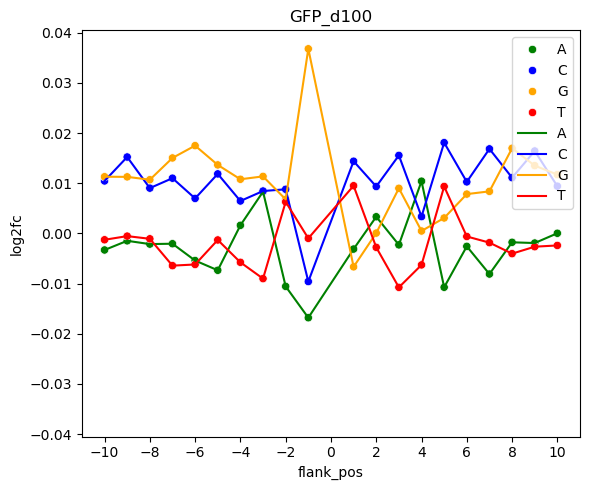

<Figure size 400x200 with 0 Axes>

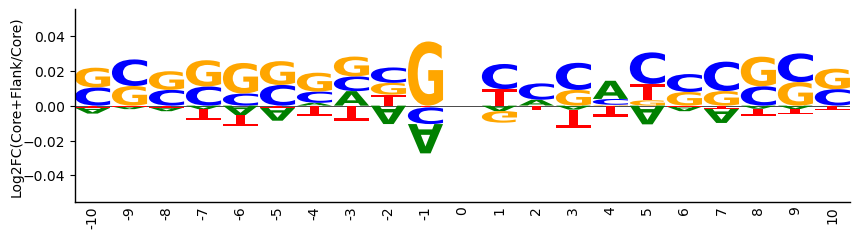

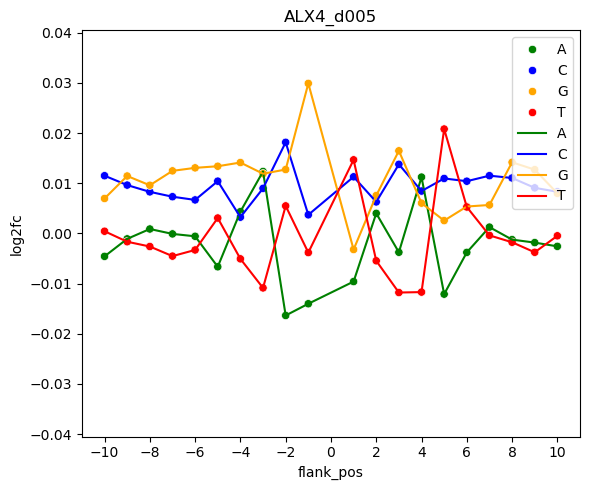

<Figure size 400x200 with 0 Axes>

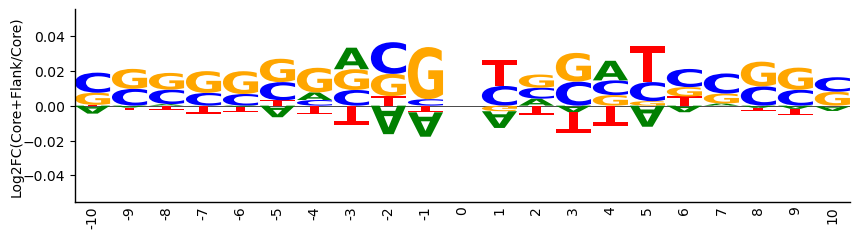

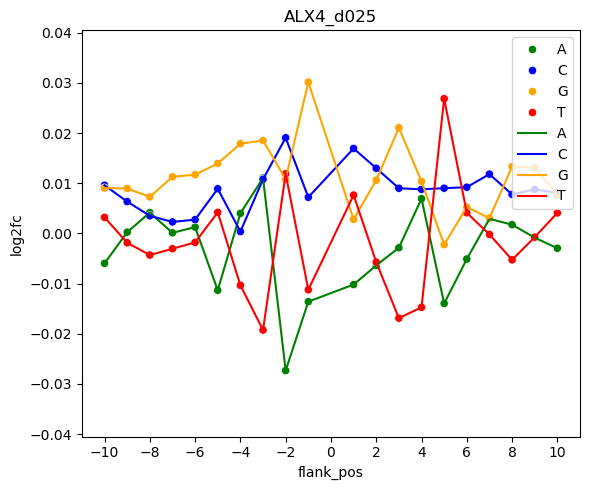

<Figure size 400x200 with 0 Axes>

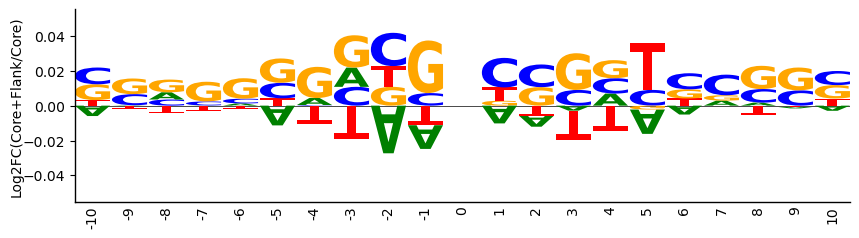

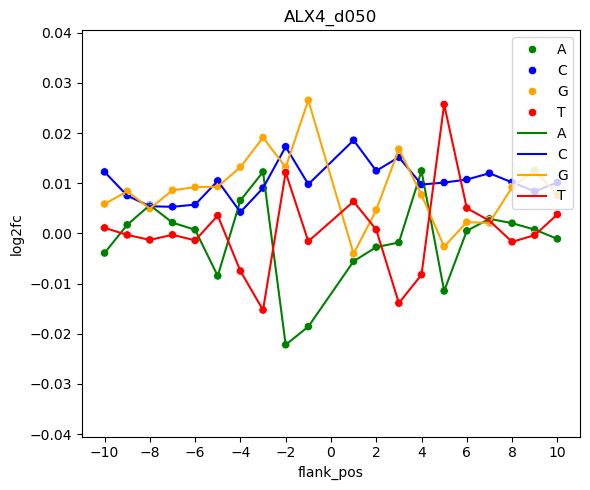

<Figure size 400x200 with 0 Axes>

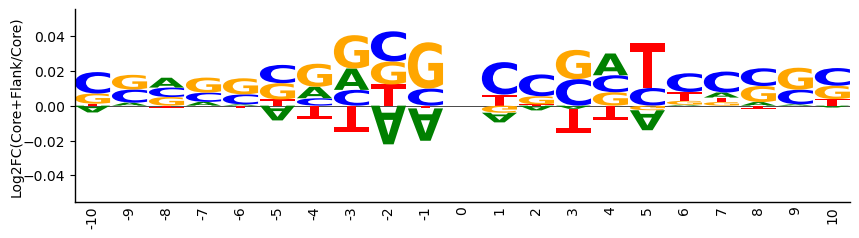

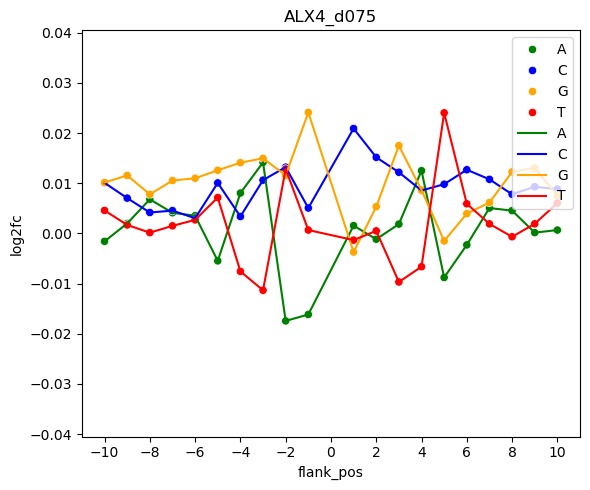

<Figure size 400x200 with 0 Axes>

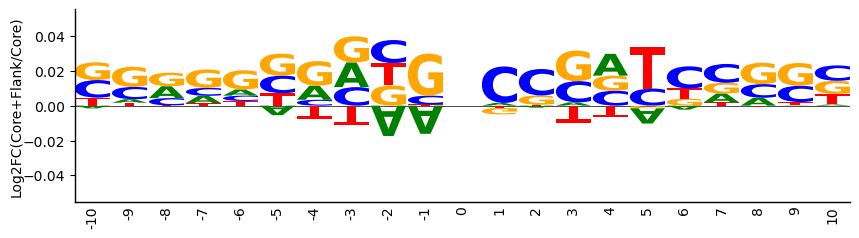

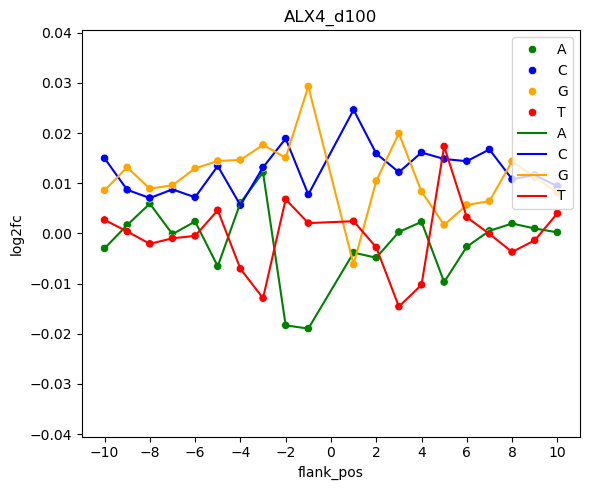

<Figure size 400x200 with 0 Axes>

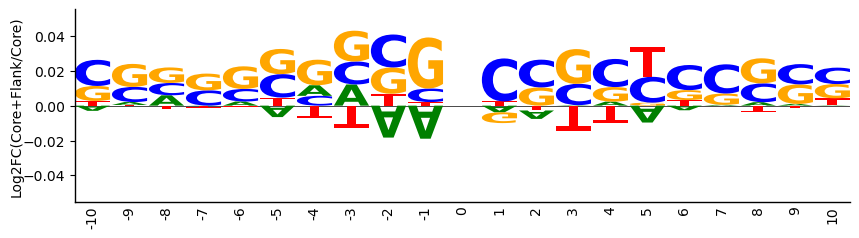

In [12]:
df = summary_all.groupby(["exp", "TF", "flank_pos", "flank_base"])["log2fc_s1"].mean().reset_index()
df["log2fc"] = df.log2fc_s1

nucleotide_colors = {"A": "green", "T": "red", "C": "blue", "G": "orange"}
dist = 10 # only look at within 10bp distances

ylims = [-np.max(np.abs(df.log2fc)) * 1.1, np.max(np.abs(df.log2fc)) * 1.1]
ylims_logo = [-np.max(np.abs(df.log2fc)) * 1.5, np.max(np.abs(df.log2fc)) * 1.5]
from scipy.stats import zscore
for exp in exp_ls:
    subset = df[(df.exp==exp) & (np.abs(df.flank_pos)<=dist)]

    unique_nucleotides = pd.unique(subset.flank_base).tolist()
    mapping = [nucleotide_colors[n] for n in unique_nucleotides]
    colormap = sns.color_palette(mapping)
    # subset["z"] = 0
    # for b in set(subset.flank_base):
    #     subset.loc[subset.flank_base==b, "z"] = zscore(list(subset.loc[subset.flank_base==b, "log2fc"]))

    #sns.scatterplot(data=subset, x="flank_pos", y="sumdiff", hue="flank_base")

    plt.figure(figsize=[6,5])
    plt.title(exp)
    plt.ylim(ylims)
    plt.xticks()
    # sns.scatterplot(data=subset, x="flank_pos", y="z", hue="flank_base")
    sns.scatterplot(data=subset, x="flank_pos", y="log2fc", hue="flank_base", palette=colormap)
    sns.lineplot(data=subset, x="flank_pos", y="log2fc", hue="flank_base", palette=colormap)
    plt.legend(loc="upper right", bbox_to_anchor=(1,1))
    plt.xticks(range(-dist,dist+1,2))
    plt.tight_layout()
    plt.savefig(f"{plotdir}/flank_effect_{TF}_{exp}_{dist}bp{suffix}.pdf", bbox_inches="tight")

    # plot seqlogo
    import logomaker
    plt.figure(figsize=[4,2])
    subset.log2fc = pd.to_numeric(subset.log2fc)
    logo_df = subset.pivot(index='flank_pos', columns='flank_base', values='log2fc')

    logo = logomaker.Logo(logo_df)
    logo.style_spines(visible=False)
    logo.style_spines(spines=['left', 'bottom'], visible=True)
    logo.style_xticks(rotation=90, fmt='%d', anchor=0)
    logo.ax.set_ylabel("Log2FC(Core+Flank/Core)", labelpad=-1)
    logo.ax.xaxis.set_ticks_position('none')
    logo.ax.xaxis.set_tick_params(pad=-1)
    logo.ax.set_ylim(ylims_logo)
    plt.savefig(f"{plotdir}/flank_effect_{TF}_{exp}_{dist}bp{suffix}_seqlogo.pdf", bbox_inches="tight")

### collapse the nucleotides in a few different ways

In [65]:
# # method 1: take the maximum abs(log2fc) at each flank_pos regardless of nucleotide to show the maximum effect any nucleotide can have
# subset["abslog2fc"] = np.abs(subset.log2fc)
# subset["abssumdiff"] = np.abs(subset.sumdiff)
# summary = pd.DataFrame(subset.groupby("flank_pos").max())[["abssumdiff","abslog2fc"]]
# summary["flank_pos"] = list(summary.index)
# summary.head()

# plt.figure()
# sns.scatterplot(data=summary, x="flank_pos", y="abslog2fc", s=10)
# sns.lineplot(data=summary, x="flank_pos", y="abslog2fc", linewidth=0.5)
# plt.axvline(0, color="red", linestyle="--", linewidth=1)
# plt.figure()
# sns.scatterplot(data=summary, x="flank_pos", y="abssumdiff", s=10)
# sns.lineplot(data=summary, x="flank_pos", y="abssumdiff", linewidth=0.5)
# plt.axvline(0, color="red", linestyle="--", linewidth=1)

In [66]:
# # method 2: calculate Shannon entropy 2 - (sum(pi*log(qi)) for i in A/T/C/G) to show if there's actually nucleotide preference at each base
# from scipy.stats import entropy
# summary = []
# for pos in pd.unique(subset.flank_pos):
#     currpos = subset[subset.flank_pos == pos]
#     summary.append([2 - entropy(list(currpos.abslog2fc), base=2), 2 - entropy(list(currpos.abssumdiff), base=2), pos])

# summary = pd.DataFrame(summary, columns=["bits_abslog2fc", "bits_abssumdiff", "flank_pos"])
# summary.head()

# plt.figure()
# sns.scatterplot(data=summary, x="flank_pos", y="bits_abslog2fc", s=10)
# sns.lineplot(data=summary, x="flank_pos", y="bits_abslog2fc", linewidth=0.5)
# plt.axvline(0, color="red", linestyle="--", linewidth=1)
# plt.figure()
# sns.scatterplot(data=summary, x="flank_pos", y="bits_abssumdiff", s=10)
# sns.lineplot(data=summary, x="flank_pos", y="bits_abssumdiff", linewidth=0.5)
# plt.axvline(0, color="red", linestyle="--", linewidth=1)

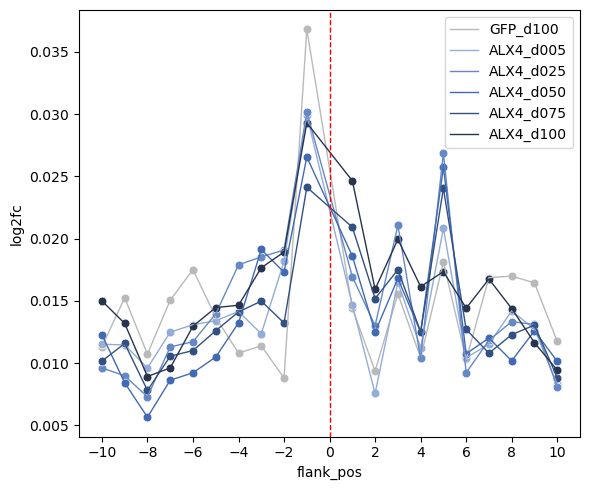

In [13]:
# method 3: take the maximum log2fc (positive) at each flank_pos regardless of nucleotide to show the maximum effect any nucleotide can have
cols = ["#B8B9BB", "#93ACD9", "#6589C6", "#426AB3", "#335082", "#28344D"]

plt.figure(figsize=[6,5])
for i in range(len(exp_ls)):
    exp = exp_ls[i]
    subset = df[(df.exp==exp) & (np.abs(df.flank_pos)<=10)]

    summary = pd.DataFrame(subset.groupby("flank_pos").max())[["log2fc"]]
    summary["flank_pos"] = list(summary.index)
    summary.head()

    sns.scatterplot(data=summary, x="flank_pos", y="log2fc", s=40, color=cols[i])
    sns.lineplot(data=summary, x="flank_pos", y="log2fc", linewidth=1, color=cols[i], label=exp)

plt.axvline(0, color="red", linestyle="--", linewidth=1)
plt.xticks(range(-10,11,2))
plt.legend(loc="upper right", bbox_to_anchor=(1,1))
plt.tight_layout()
# plt.ylim(-0.002, 0.145)
# plt.ylim(0.003, 0.075)
plt.savefig(f"{plotdir}/flank_effect_max_{TF}_{dist}bp{suffix}.pdf", bbox_inches='tight')



/tmp/ipykernel_93548/559769394.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset.log2fc = list(subset.log2fc)
/tmp/ipykernel_93548/559769394.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset.log2fc = list(subset.log2fc)
/tmp/ipykernel_93548/559769394.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

1    GGGCCSCCGGG
1    GAAGCSGTGGG
1    GAAGCSGTGGG
1    GAGGCSGTGGC
1    GAGGCSGTGGG
1    GAGGCSGTGGG
Name: seq, dtype: object
2    ATTTTSTAAAT
2    TTTTTSTATTT
2    TCCTTSTATTA
2    TCTTTSTATTT
2    TTTTTSTATTT
2    TTCTTSTATTT
Name: seq, dtype: object


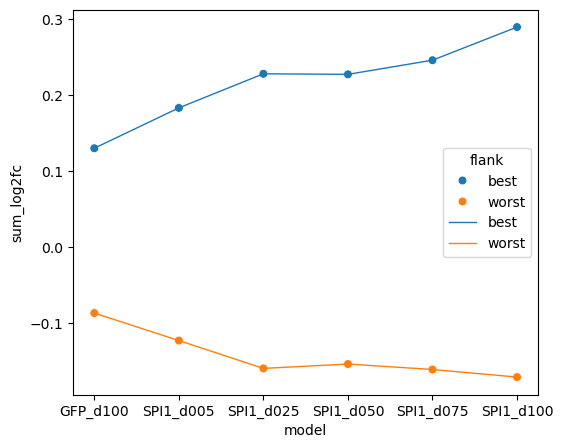

In [32]:
# plot a best flank vs worst flank vs no flank line plot
plt.figure(figsize=[6,5])
output = []
window = 5 # smaller window 
core = params[0][0][0]

for i in range(len(exp_ls)):
    exp = exp_ls[i]
    subset = df[(df.exp==exp) & (np.abs(df.flank_pos)<=window)] 
    subset.log2fc = list(subset.log2fc)
    subset = subset.reset_index()
    best = subset.loc[subset.groupby('flank_pos')['log2fc'].idxmax()]
    best.head()
    worst = subset.loc[subset.groupby('flank_pos')['log2fc'].idxmin()]

    best_flank = ''.join(best.sort_values(by="flank_pos").flank_base) # best flanking sequence
    worst_flank = ''.join(worst.sort_values(by="flank_pos").flank_base) # worst flanking sequence
    best_seq = best_flank[:window] + core + best_flank[window:]
    worst_seq = worst_flank[:window] + core + worst_flank[window:]
    
    output.append(pd.DataFrame({"sum_log2fc": [best.log2fc.sum(), worst.log2fc.sum()], "flank": ["best", "worst"],
                                "model": [exp, exp], "seq": [best_seq, worst_seq]}, index=[1,2]))

output = pd.concat(output)
sns.scatterplot(data=output, x="model", y="sum_log2fc", s=40, hue="flank")
sns.lineplot(data=output, x="model", y="sum_log2fc", linewidth=1, hue="flank")
print(output[output.flank=="best"].seq)
print(output[output.flank=="worst"].seq)
    
# sns.scatterplot(data=toplot, x="spacing", y="sumdiff", hue="motif")
# sns.lineplot(data=toplot, x="spacing", y="sumdiff", hue="motif")
# plt.xlabel("distance in bp")
# plt.ylabel("sum of predicted counts diff between motif and bgd")
# plt.savefig(f"{plotdir}/lineplots/lineplot_sumdiff_HH_HT_TT_{suffix}_bgdbase.pdf", dpi=150)


## plot coop effects

In [7]:
# TF cooperativity
c = inputlen//2
baseTF = "SPI1"
partners = {"CTCF": "CGCCCCCTGGTGG",
            "KLF": "CCACGCCCA",
            "NFY": "CCAAT",
            "HOX": "GCCATAAA",
            "FOSv1": "TGACGTCA",
            "FOSv2": "TGACTCAT",
            "NRF1": "GCGCATGCGC",
            "SIX": "TGTAACCTGATAC"}
# coopTF = "CTCF"
# suffix = "SPI1_coop_ETS_CTCF"
# params = [[["GGAA"], [c], "ETS_single"]] + \
#          [[["GGAA", partners[coopTF]], [c, c-i-len(partners[coopTF])+1], f"{baseTF}_coop_{coopTF}_left_{i}bp"] for i in range(1,51)] + \
#          [[["GGAA", partners[coopTF]], [c, c+len("GGAA")-1+i], f"{baseTF}_coop_{coopTF}_right_{i}bp"] for i in range(1,51)]
# suffix = "SPI1_coop_CTCFbase_ETS"
# params = [[[partners[coopTF]], [c], coopTF]] + \
#          [[["GGAA", partners[coopTF]], [c, c-i-len(partners[coopTF])+1], f"{baseTF}_coop_{coopTF}_left_{i}bp"] for i in range(1,51)] + \
#          [[["GGAA", partners[coopTF]], [c, c+len("GGAA")-1+i], f"{baseTF}_coop_{coopTF}_right_{i}bp"] for i in range(1,51)]

coopTF = "HOX"
suffix = f"SPI1_coop_ETS_{coopTF}"
#params = [[["GGAA"], [c], "ETS_single"]] + \
#params = [[["CCAAT"], [c], "NFY_single"]] + \
params = [[[partners[coopTF]], [c], f"{coopTF}_single"]] + \
         [[["GGAA", partners[coopTF]], [c, c-i-len(partners[coopTF])+1], f"{baseTF}_coop_{coopTF}_left_{i}bp"] for i in range(1,51)] + \
         [[["GGAA", partners[coopTF]], [c, c+len("GGAA")-1+i], f"{baseTF}_coop_{coopTF}_right_{i}bp"] for i in range(1,51)]


for p in params[1:10]:
    print(p)
    
print(len(params))

[['GGAA', 'GCCATAAA'], [1057, 1049], 'SPI1_coop_HOX_left_1bp']
[['GGAA', 'GCCATAAA'], [1057, 1048], 'SPI1_coop_HOX_left_2bp']
[['GGAA', 'GCCATAAA'], [1057, 1047], 'SPI1_coop_HOX_left_3bp']
[['GGAA', 'GCCATAAA'], [1057, 1046], 'SPI1_coop_HOX_left_4bp']
[['GGAA', 'GCCATAAA'], [1057, 1045], 'SPI1_coop_HOX_left_5bp']
[['GGAA', 'GCCATAAA'], [1057, 1044], 'SPI1_coop_HOX_left_6bp']
[['GGAA', 'GCCATAAA'], [1057, 1043], 'SPI1_coop_HOX_left_7bp']
[['GGAA', 'GCCATAAA'], [1057, 1042], 'SPI1_coop_HOX_left_8bp']
[['GGAA', 'GCCATAAA'], [1057, 1041], 'SPI1_coop_HOX_left_9bp']
101


In [ ]:
outdir = f"{base_dir}/output/02-atac/14/HEK293T_{baseTF}/marginalize/coop/"
plotdir = f"{base_dir}/plots/02-atac/14/HEK293T_{baseTF}/marginalize/coop/"

exp_ls = ["GFP_d100", "SPI1_d005", "SPI1_d025", "SPI1_d050", "SPI1_d075", "SPI1_d100"]
# exp_ls = ["GFP_d100", "KLF1_d005", "KLF1_d025", "KLF1_d050", "KLF1_d075", "KLF1_d100"]

# load control 
motifs, motif_starts, name = params[0]
df_ctl = pd.read_csv(f"{outdir}/insert_{name}_{n_bgd}bgd.csv", sep=",")
df2_ctl = pd.read_csv(f"{outdir}/insert_{name}_{n_bgd}bgd_avglogits.csv", sep=",")

os.makedirs(f"{plotdir}/tracks", exist_ok=True)
sumdiff_all = []
for k in range(1,len(params)):
    motifs, motif_starts, name = params[k]
    
    try:
        df = pd.read_csv(f"{outdir}/insert_{name}_{n_bgd}bgd.csv", sep=",")
        df2 = pd.read_csv(f"{outdir}/insert_{name}_{n_bgd}bgd_avglogits.csv", sep=",")
    except:
        continue
    fig, ax = plt.subplots(len(exp_ls)+1,1, figsize=(20,18))
    cols = ["black", "blue", "green", "orange", "red", "magenta"]
    sumdiff = []
    log2fc = []
    for i in range(len(exp_ls)):
        n = exp_ls[i]
        avg_probs = softmax(df2_ctl[f"synth_pred_avglogits_{n}"])
        avg_counts_base = np.exp(df_ctl[f"synth_pred_counts_{n}"]).mean()
        avg_profile_base = avg_probs * avg_counts_base

        avg_probs = softmax(df2[f"synth_pred_avglogits_{n}"])
        avg_counts_synth = np.exp(df[f"synth_pred_counts_{n}"]).mean()
        avg_profile_synth = avg_probs * avg_counts_synth

        sumdiff.append(avg_counts_synth - avg_counts_base)
        log2fc.append(np.log2(avg_counts_synth/avg_counts_base))
        sns.lineplot(avg_profile_synth - avg_profile_base, label=n, color=cols[i], ax=ax[0])

        sns.lineplot(avg_profile_base, label=params[0][2], color="gray", ax=ax[i+1])
        sns.lineplot(avg_profile_synth, label=n, color=cols[i], ax=ax[i+1])
        ax[i+1].set_ylabel("predicted counts")
    sumdiff_all.append(pd.DataFrame([exp_ls, sumdiff, log2fc, [name]*len(sumdiff)], index=["exp", "sumdiff", "log2fc","name"]).transpose())
    ax[0].set_title(f"inserted {name}")
    ax[0].set_ylabel(f"predicted counts (synth - {params[0][2]})")
    plt.xlabel("bp position")
    # highlight the motif locations
    for a in ax:
        for j in range(len(motifs)):
            pos_to_insert = motif_starts[j] - (inputlen - outputlen)//2 
            a.axvspan(pos_to_insert, pos_to_insert + len(motifs[j]), ymin=0, ymax=1, alpha=0.2, color='red')    
    plt.tight_layout()
    plt.savefig(f"{plotdir}/tracks/track_insert_{name}_{n_bgd}bgd_{params[0][2]}base.pdf", dpi=150)

sumdiff_all = pd.concat(sumdiff_all, axis=0)


In [ ]:
sumdiff_all["coop_dir"] = np.array([n.split("_")[3] for n in list(sumdiff_all.name)])
sumdiff_all["coop_pos"] = np.array([int(n.split("_")[4].split("bp")[0]) for n in list(sumdiff_all.name)])
sumdiff_all.loc[sumdiff_all.coop_dir=="left", "coop_pos"] = - sumdiff_all.loc[sumdiff_all.coop_dir=="left", "coop_pos"]
print(sumdiff_all.head())
sumdiff_all.shape

In [ ]:
os.makedirs(f"{plotdir}/lineplots", exist_ok=True)

plt.figure(figsize=(8,8))
sns.lineplot(data=sumdiff_all, x="exp", y="sumdiff", hue="name")
plt.xlabel("model")
plt.ylabel(f"sum of predicted counts diff between {params[0][2]} and ETS single+{coopTF}")
plt.legend().set_visible(False)
plt.savefig(f"{plotdir}/lineplots/lineplot_insert_comparison_{n_bgd}bgd_{params[0][2]}base_{suffix}.pdf", dpi=150)

plt.figure(figsize=(8,8))
sns.lineplot(data=sumdiff_all, x="exp", y="log2fc", hue="name")
plt.xlabel("model")
plt.ylabel(f"log2fc of counts between {params[0][2]} and ETS single+{coopTF}")
plt.legend().set_visible(False) # use this when too many lines
plt.savefig(f"{plotdir}/lineplots/lineplot_insert_comparison_log2fc_{n_bgd}bgd_{params[0][2]}base_{suffix}.pdf", dpi=150)

# sumdiff_all["spacing"] = np.array([int(n.split("_")[2].split("bp")[0]) for n in list(sumdiff_all.name)])
plt.figure(figsize=(8,8))
sns.scatterplot(data=sumdiff_all, x="coop_pos", y="sumdiff", hue="exp")
sns.lineplot(data=sumdiff_all, x="coop_pos", y="sumdiff", hue="exp")
plt.xlabel("distance in bp")
plt.ylabel(f"sum of predicted counts diff between {params[0][2]} and ETS single+{coopTF}")
plt.savefig(f"{plotdir}/lineplots/lineplot_insert_comparison_spacing_{n_bgd}bgd_{params[0][2]}base_{suffix}.pdf", dpi=150)

plt.figure(figsize=(8,8))
sns.scatterplot(data=sumdiff_all, x="coop_pos", y="log2fc", hue="exp")
sns.lineplot(data=sumdiff_all, x="coop_pos", y="log2fc", hue="exp")
plt.xlabel("distance in bp")
plt.ylabel(f"log2fc of counts between {params[0][2]} and ETS single+{coopTF}")
plt.savefig(f"{plotdir}/lineplots/lineplot_insert_comparison_spacing_log2fc_{n_bgd}bgd_{params[0][2]}base_{suffix}.pdf", dpi=150)

### is 1+1>2?

In [12]:
# TF cooperativity
c = inputlen//2
baseTF = "ELF1"
partners_raw = {"SPI1": {"SPI1": "GGAA", # first one is the base TF
                    "CTCF": "CGCCCCCTGGTGG",
                    "KLF": "CCACGCCCA",
                    "NFY": "CCAAT",
                    "HOX": "GCCATAAA",
                    "FOSv1": "TGACGTCA", #bzip
                    "FOSv2": "TGACTCAT", #bzip
                    "NRF1": "GCGCATGCGC",
                    "SIX": "TGTAACCTGATAC"},
            "KLF1": {"KLF1": "CCCCGCCCC", # first one is the base TF
                    "CTCF": "CGCCCCCTGGTGG",
                    "FOSv1": "TGACGTCA", #bzip
                    "FOSv2": "TGACTCAT", #bzip
                    "ETS": "CCGGAAGT",
                    "NRF1": "GCGCATGCGC",
                    "SIX": "TGTAACCTGATAC",
                    "ZNF143": "CTGGGAAATGTAGTCC" # chrombpnet pattern matches hocomoco ZNF143 motif not the JASPAR one
                    },
            "ELF1": {"ELF1": "GGAA", # first one is the base TF
                    "CTCF": "CGCCCCCTGGTGG",
                    "KLFstrong": "CCACGCCCA",
                    "KLFweak": "CCCCGCCCC", 
                    "bHLH": "GTCACGTGAC",
                    "FOX": "TGTTTACTT",
                    "HOX": "GCCATAAA",
                    "NFY": "CCAAT",
                    "FOSv1": "TGACGTCA", #bzip
                    "FOSv2": "TGACTCAT", #bzip
                    "NRF1": "GCGCATGCGC",
                    "SIX": "TGTAACCTGATAC",
                    "ZNF143": "CTGGGAAATGTAGTCC" # chrombpnet pattern matches hocomoco ZNF143 motif not the JASPAR one
                    }
            }
baseTF_motif = partners_raw[baseTF][baseTF]
partners = partners_raw[baseTF]
partners.pop(baseTF)


coopTF = "ZNF143"
suffix = f"{baseTF}_coop_{baseTF}_{coopTF}"
# params = [[["GGAA"], [c], "ETS_single"]] + \
#          [[["CCACGCCCA"], [c], "KLF_single"]] + \
#          [[["GGAA", partners[coopTF]], [c, c-i-len(partners[coopTF])+1], f"{baseTF}_coop_{coopTF}_left_{i}bp"] for i in range(1,51)] + \
#          [[["GGAA", partners[coopTF]], [c, c+len("GGAA")-1+i], f"{baseTF}_coop_{coopTF}_right_{i}bp"] for i in range(1,51)]

params = [[[baseTF_motif], [c], f"{baseTF}_single"]] + \
         [[[partners[coopTF]], [c], f"{coopTF}_single"]] + \
         [[[baseTF_motif, partners[coopTF]], [c, c-i-len(partners[coopTF])+1], f"{baseTF}_coop_{coopTF}_left_{i}bp"] for i in range(1,51)] + \
         [[[baseTF_motif, partners[coopTF]], [c, c+len(baseTF_motif)-1+i], f"{baseTF}_coop_{coopTF}_right_{i}bp"] for i in range(1,51)]


for p in params[:10]:
    print(p)

print(len(params))

[['GGAA'], [1057], 'ELF1_single']
[['CTGGGAAATGTAGTCC'], [1057], 'ZNF143_single']
[['GGAA', 'CTGGGAAATGTAGTCC'], [1057, 1041], 'ELF1_coop_ZNF143_left_1bp']
[['GGAA', 'CTGGGAAATGTAGTCC'], [1057, 1040], 'ELF1_coop_ZNF143_left_2bp']
[['GGAA', 'CTGGGAAATGTAGTCC'], [1057, 1039], 'ELF1_coop_ZNF143_left_3bp']
[['GGAA', 'CTGGGAAATGTAGTCC'], [1057, 1038], 'ELF1_coop_ZNF143_left_4bp']
[['GGAA', 'CTGGGAAATGTAGTCC'], [1057, 1037], 'ELF1_coop_ZNF143_left_5bp']
[['GGAA', 'CTGGGAAATGTAGTCC'], [1057, 1036], 'ELF1_coop_ZNF143_left_6bp']
[['GGAA', 'CTGGGAAATGTAGTCC'], [1057, 1035], 'ELF1_coop_ZNF143_left_7bp']
[['GGAA', 'CTGGGAAATGTAGTCC'], [1057, 1034], 'ELF1_coop_ZNF143_left_8bp']
102


In [ ]:
%%capture

outdir = f"{base_dir}/output/02-atac/14/HEK293T_{baseTF}/marginalize/coop"
plotdir = f"{base_dir}/plots/02-atac/14/HEK293T_{baseTF}/marginalize/coop"

# exp_ls = ["GFP_d100", "SPI1_d005", "SPI1_d025", "SPI1_d050", "SPI1_d075", "SPI1_d100"]
exp_ls = ["GFP_d100", f"{baseTF}_d005", f"{baseTF}_d025", f"{baseTF}_d050", f"{baseTF}_d075", f"{baseTF}_d100"]

# load control 
motifs, motif_starts, name = params[0]
df_ctl_tf1 = pd.read_csv(f"{outdir}/insert_{name}_{n_bgd}bgd.csv", sep=",")
df2_ctl_tf1 = pd.read_csv(f"{outdir}/insert_{name}_{n_bgd}bgd_avglogits.csv", sep=",")

motifs, motif_starts, name = params[1]
df_ctl_tf2 = pd.read_csv(f"{outdir}/insert_{name}_{n_bgd}bgd.csv", sep=",")
df2_ctl_tf2 = pd.read_csv(f"{outdir}/insert_{name}_{n_bgd}bgd_avglogits.csv", sep=",")

os.makedirs(f"{plotdir}/tracks", exist_ok=True)
sumdiff_all = []
for k in range(2,len(params)):
    motifs, motif_starts, name = params[k]

    try:
        df = pd.read_csv(f"{outdir}/insert_{name}_{n_bgd}bgd.csv", sep=",")
        df2 = pd.read_csv(f"{outdir}/insert_{name}_{n_bgd}bgd_avglogits.csv", sep=",")
    except:
        continue
    
    fig, ax = plt.subplots(len(exp_ls)+1,1, figsize=(20,18))
    cols = ["black", "blue", "green", "orange", "red", "magenta"]
    sumdiff = []
    log2fc = []
    for i in range(len(exp_ls)):
        n = exp_ls[i]
        avg_probs = softmax(df2_ctl_tf1[f"synth_pred_avglogits_{n}"])
        avg_counts_base_tf1 = np.exp(df_ctl_tf1[f"synth_pred_counts_{n}"]).mean()
        avg_profile_base_tf1 = avg_probs * avg_counts_base_tf1
        avg_profile_base_tf1 = avg_profile_base_tf1 - np.ravel([avg_profile_base_tf1[0:50], avg_profile_base_tf1[950:1000]]).mean()

        avg_probs = softmax(df2_ctl_tf2[f"synth_pred_avglogits_{n}"])
        avg_counts_base_tf2 = np.exp(df_ctl_tf2[f"synth_pred_counts_{n}"]).mean()
        avg_profile_base_tf2 = avg_probs * avg_counts_base_tf2
        avg_profile_base_tf2 = avg_profile_base_tf2 - np.ravel([avg_profile_base_tf2[0:50], avg_profile_base_tf2[950:1000]]).mean()
        
        avg_probs = softmax(df2[f"synth_pred_avglogits_{n}"])
        avg_counts_synth = np.exp(df[f"synth_pred_counts_{n}"]).mean()
        avg_profile_synth = avg_probs * avg_counts_synth
        avg_profile_synth = avg_profile_synth - np.ravel([avg_profile_synth[0:50], avg_profile_synth[950:1000]]).mean()

        sumdiff.append(sum(avg_profile_synth - avg_profile_base_tf1 - avg_profile_base_tf2))
        log2fc.append(np.log2(sum(avg_profile_synth)/sum(avg_profile_base_tf1 + avg_profile_base_tf2))) # this returns NaN if sum(avg_profile_synth) is negative
        
        # shift tf2 logits by flank shift and pad with zeros for plotting
        shift = motif_starts[1] - motif_starts[0]
        left = max(0, 0-shift)
        right = min(outputlen, outputlen-shift)
        vals_shifted = [[0]*(outputlen-right), avg_profile_base_tf2[left:right], [0]*(left-0)]
        avg_profile_base_tf2_padded = [i for n in vals_shifted for i in n]

        sns.lineplot(avg_profile_synth - avg_profile_base_tf1 - avg_profile_base_tf2_padded, label=n, color=cols[i], ax=ax[0])

        sns.lineplot(avg_profile_base_tf1, label=params[0][2], color="lightgray", ax=ax[i+1])
        sns.lineplot(avg_profile_base_tf2_padded, label=params[1][2], color="dimgray", ax=ax[i+1])
        sns.lineplot(avg_profile_base_tf1 + avg_profile_base_tf2_padded, label="sum", color="slategrey", ax=ax[i+1])

        sns.lineplot(avg_profile_synth, label=n+ " combined", color=cols[i], ax=ax[i+1])
        ax[i+1].set_ylabel("predicted counts")

    sumdiff_all.append(pd.DataFrame([exp_ls, sumdiff, log2fc, [name]*len(sumdiff)], index=["exp", "sumdiff", "log2fc","name"]).transpose())
    ax[0].set_title(f"inserted {name}")
    ax[0].set_ylabel(f"predicted counts (synth - ({params[0][2]}+{params[1][2]}))")
    plt.xlabel("bp position")
    # highlight the motif locations
    for a in ax:
        for j in range(len(motifs)):
            pos_to_insert = motif_starts[j] - (inputlen - outputlen)//2 
            a.axvspan(pos_to_insert, pos_to_insert + len(motifs[j]), ymin=0, ymax=1, alpha=0.2, color='red')    
    plt.tight_layout()
    plt.savefig(f"{plotdir}/tracks/track_insert_{name}_{n_bgd}bgd_{params[0][2]}PLUS{params[1][2]}base.pdf", dpi=150)
    plt.close()

sumdiff_all = pd.concat(sumdiff_all, axis=0)
sumdiff_all["coop_dir"] = np.array([n.split("_")[3] for n in list(sumdiff_all.name)])
sumdiff_all["coop_pos"] = np.array([int(n.split("_")[4].split("bp")[0]) for n in list(sumdiff_all.name)])
sumdiff_all.loc[sumdiff_all.coop_dir=="left", "coop_pos"] = - sumdiff_all.loc[sumdiff_all.coop_dir=="left", "coop_pos"]
print(sumdiff_all.head())
sumdiff_all.shape

In [14]:
## only run this if you run into an issue where sum(avg_profile_synth) is negative after rebasing
# sumdiff_all.loc[sumdiff_all.log2fc.isna(), "log2fc"] = np.min(sumdiff_all.log2fc)

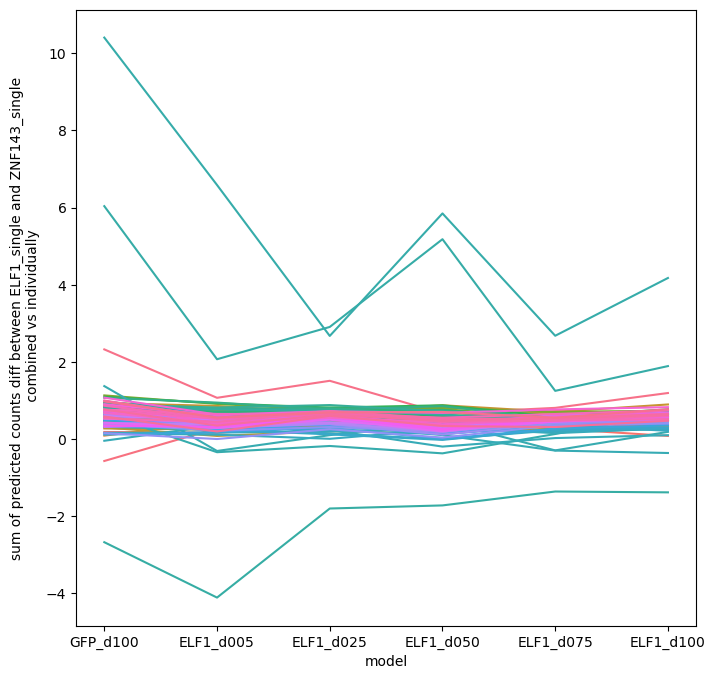

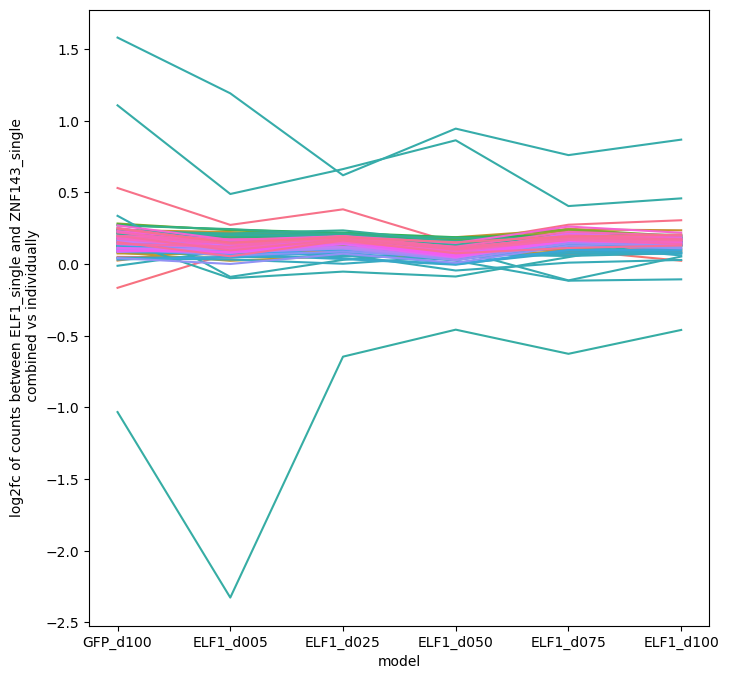

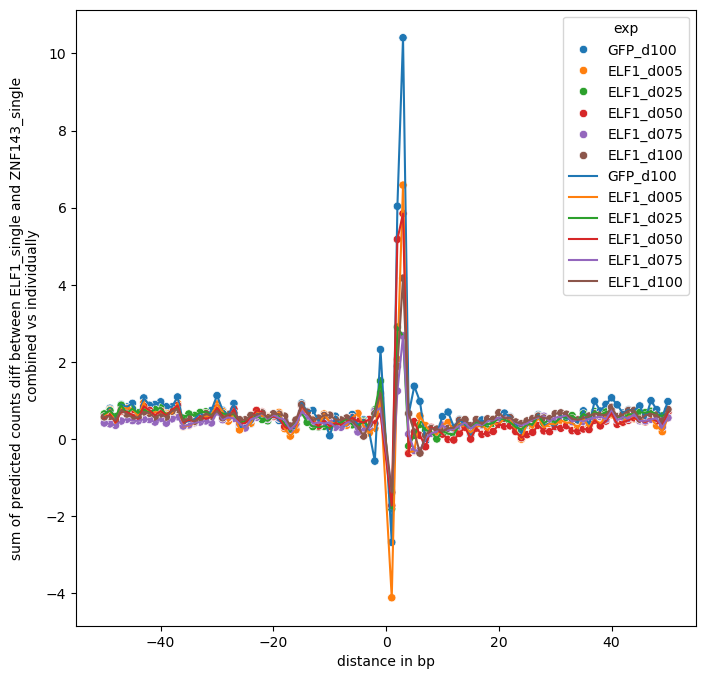

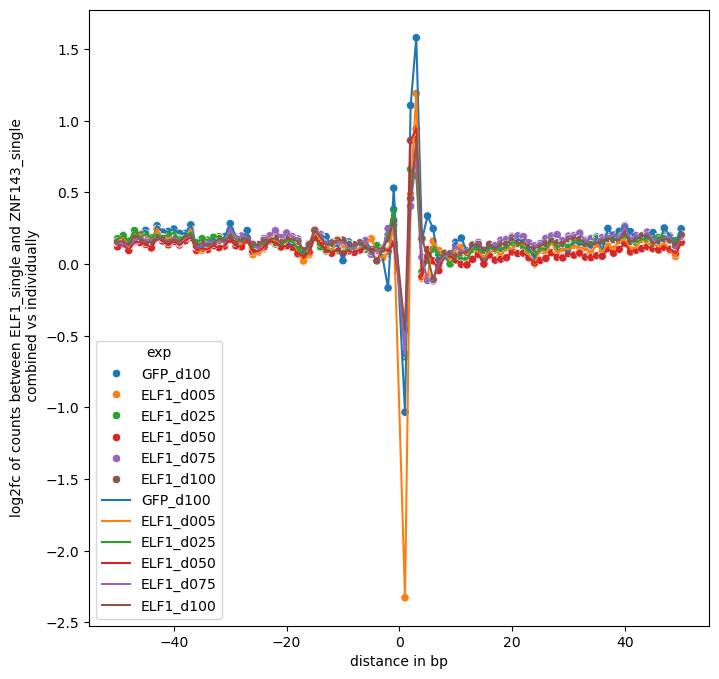

In [15]:
os.makedirs(f"{plotdir}/lineplots", exist_ok=True)

plt.figure(figsize=(8,8))
sns.lineplot(data=sumdiff_all, x="exp", y="sumdiff", hue="name")
plt.xlabel("model")
plt.ylabel(f"sum of predicted counts diff between {params[0][2]} and {params[1][2]}\n combined vs individually")
plt.legend().set_visible(False)
plt.savefig(f"{plotdir}/lineplots/lineplot_insert_comparison_{n_bgd}bgd_{params[0][2]}PLUS{params[1][2]}base_{suffix}.pdf", dpi=150)


plt.figure(figsize=(8,8))
sns.lineplot(data=sumdiff_all, x="exp", y="log2fc", hue="name")
plt.xlabel("model")
plt.ylabel(f"log2fc of counts between {params[0][2]} and {params[1][2]}\n combined vs individually")
plt.legend().set_visible(False) # use this when too many lines
plt.savefig(f"{plotdir}/lineplots/lineplot_insert_comparison_log2fc_{n_bgd}bgd_{params[0][2]}PLUS{params[1][2]}base_{suffix}.pdf", dpi=150)

plt.figure(figsize=(8,8))
sns.scatterplot(data=sumdiff_all, x="coop_pos", y="sumdiff", hue="exp")
sns.lineplot(data=sumdiff_all, x="coop_pos", y="sumdiff", hue="exp")
plt.xlabel("distance in bp")
plt.ylabel(f"sum of predicted counts diff between {params[0][2]} and {params[1][2]}\n combined vs individually")
plt.savefig(f"{plotdir}/lineplots/lineplot_insert_comparison_spacing_{n_bgd}bgd_{params[0][2]}PLUS{params[1][2]}base_{suffix}.pdf", dpi=150)

plt.figure(figsize=(8,8))
sns.scatterplot(data=sumdiff_all, x="coop_pos", y="log2fc", hue="exp")
sns.lineplot(data=sumdiff_all, x="coop_pos", y="log2fc", hue="exp")
plt.xlabel("distance in bp")
plt.ylabel(f"log2fc of counts between {params[0][2]} and {params[1][2]}\n combined vs individually")
plt.savefig(f"{plotdir}/lineplots/lineplot_insert_comparison_spacing_log2fc_{n_bgd}bgd_{params[0][2]}PLUS{params[1][2]}base_{suffix}.pdf", dpi=150)

## plot multifold model diffs

In [ ]:
TF = "SPI1"
c = inputlen//2
nucleo = ["A", "T", "C", "G"]

# params_raw = [[["GGAA"], [c], "ETS_single"]] + \
#             [[["GGAA", "GGAA"], [c, c+i], f"ETS_HT_{i}bp"] for i in range(4,50)] + \
#             [[["GGAA", "TTCC"], [c, c+i], f"ETS_HH_{i}bp"] for i in range(4,50)] + \
#             [[["TTCC", "GGAA"], [c, c+i], f"ETS_TT_{i}bp"] for i in range(4,50)] + \
#             [[["GGAA", j], [c, c-i], f"GGAA_flank_left_{i}bp_{j}"] for i in range(1,50) for j in nucleo] + \
#             [[["GGAA", j], [c, c+len("GGAA")-1+i], f"GGAA_flank_right_{i}bp_{j}"] for i in range(1,50) for j in nucleo]

params = [[["GGAA"], [c], "ETS_single"]] + \
            [[["GGAA", "GGAA"], [c, c+i], f"ETS_HT_{i}bp"] for i in range(4,50)] + \
            [[["GGAA", "TTCC"], [c, c+i], f"ETS_HH_{i}bp"] for i in range(4,50)] + \
            [[["TTCC", "GGAA"], [c, c+i], f"ETS_TT_{i}bp"] for i in range(4,50)] 


In [ ]:
outdir = f"{base_dir}/output/02-atac/14/HEK293T_{TF}/marginalize/multifold"
plotdir = f"{base_dir}/plots/02-atac/14/HEK293T_{TF}/marginalize/multifold"

exp_ls = ["GFP_d100", "SPI1_d005", "SPI1_d025", "SPI1_d050", "SPI1_d075", "SPI1_d100"]
fold_ls = [str(n) for n in [0,1,2,3,4]]

# load control 
motifs, motif_starts, name = params[0]
df_ctl = pd.read_csv(f"{outdir}/insert_{name}_{n_bgd}bgd.csv", sep=",")
df2_ctl = pd.read_csv(f"{outdir}/insert_{name}_{n_bgd}bgd_avglogits.csv", sep=",")

sumdiff_all = []
for k in range(1,len(params)):
    motifs, motif_starts, name = params[k]

    try:
        df = pd.read_csv(f"{outdir}/insert_{name}_{n_bgd}bgd.csv", sep=",")
        df2 = pd.read_csv(f"{outdir}/insert_{name}_{n_bgd}bgd_avglogits.csv", sep=",")
    except:
        continue

    # fig, ax = plt.subplots(len(exp_ls)+1,1, figsize=(20,18))
    cols = ["black", "blue", "green", "orange", "red", "magenta"]
    sumdiff = []
    log2fc = []
    folds = []
    exps = []
    for i in range(len(exp_ls)):
        n = exp_ls[i]
        # avg across bgd per fold
        for f in fold_ls:
            avg_probs = softmax(df2_ctl[f"synth_pred_avglogits_{n}_fold{f}"])
            avg_counts_base = np.exp(df_ctl[f"synth_pred_counts_{n}_fold{f}"]).mean()
            avg_profile_base = avg_probs * avg_counts_base

            avg_probs = softmax(df2[f"synth_pred_avglogits_{n}_fold{f}"])
            avg_counts_synth = np.exp(df[f"synth_pred_counts_{n}_fold{f}"]).mean()
            avg_profile_synth = avg_probs * avg_counts_synth

            sumdiff.append(sum(avg_profile_synth - avg_profile_base))
            log2fc.append(np.log2(avg_counts_synth/avg_counts_base))
            folds.append(f"fold_{f}")

        # avg across fold, across bgd
        avg_probs = softmax(df2_ctl[f"synth_pred_avglogits_{n}"])
        avg_counts_base = np.exp(df_ctl[f"synth_pred_counts_{n}"]).mean()
        avg_profile_base = avg_probs * avg_counts_base

        avg_probs = softmax(df2[f"synth_pred_avglogits_{n}"])
        avg_counts_synth = np.exp(df[f"synth_pred_counts_{n}"]).mean()
        avg_profile_synth = avg_probs * avg_counts_synth

        sumdiff.append(sum(avg_profile_synth - avg_profile_base))
        log2fc.append(np.log2(avg_counts_synth/avg_counts_base))
        folds.append("fold_avg")
        exps.extend([n]*(len(fold_ls)+1))

        # sns.lineplot(avg_profile_synth - avg_profile_base, label=n, color=cols[i], ax=ax[0])

        # sns.lineplot(avg_profile_base, label=f"ETS single", color="gray", ax=ax[i+1])
        # sns.lineplot(avg_profile_synth, label=n, color=cols[i], ax=ax[i+1])
        # ax[i+1].set_ylabel("predicted counts")

    sumdiff_all.append(pd.DataFrame([exps, sumdiff, log2fc, folds, [name]*len(sumdiff)], index=["exp", "sumdiff", "log2fc", "fold", "name"]).transpose())
    # ax[0].set_title(f"inserted {name}")
    # ax[0].set_ylabel("predicted counts (synth - single ETS)")
    # plt.xlabel("bp position")

    # highlight the motif locations
    # for a in ax:
    #     for j in range(len(motifs)):
    #         pos_to_insert = motif_starts[j] - (inputlen - outputlen)//2 
    #         a.axvspan(pos_to_insert, pos_to_insert + len(motifs[j]), ymin=0, ymax=1, alpha=0.2, color='red')
    
    # plt.tight_layout()
    # plt.savefig(f"{plotdir}/tracks/track_insert_{name}_{n_bgd}bgd_ETSsinglebase.pdf", dpi=150)

sumdiff_all = pd.concat(sumdiff_all, axis=0)
print(sumdiff_all.shape)
sumdiff_all.head()


In [ ]:
sumdiff_all["spacing"] = np.array([int(n.split("_")[2].split("bp")[0]) for n in list(sumdiff_all.name)])
sumdiff_all["motif"] = np.array([n.split("_")[1] for n in list(sumdiff_all.name)])
sumdiff_all.head()

In [ ]:
# model = "SPI1_d100"
model = "SPI1_d100"
suffix = "SPI1_d100_multifold"
toplot = sumdiff_all[sumdiff_all.exp==model]

os.makedirs(f"{plotdir}/lineplots", exist_ok=True)

plt.figure(figsize=(8,8))
sns.scatterplot(data=toplot, x="spacing", y="sumdiff", hue="motif")
sns.lineplot(data=toplot, x="spacing", y="sumdiff", hue="motif")
plt.xlabel("distance in bp")
plt.ylabel("sum of predicted counts diff between motif and bgd")
plt.savefig(f"{plotdir}/lineplots/lineplot_sumdiff_HH_HT_TT_{suffix}_ETSsinglebase.pdf", dpi=150)

plt.figure(figsize=(8,8))
sns.scatterplot(data=toplot, x="spacing", y="log2fc", hue="motif")
sns.lineplot(data=toplot, x="spacing", y="log2fc", hue="motif")
plt.xlabel("distance in bp")
plt.ylabel("log2fc of counts between motif and bgd")
plt.savefig(f"{plotdir}/lineplots/lineplot_log2fc_HH_HT_TT_{suffix}_ETSsinglebase.pdf", dpi=150)

plt.figure(figsize=(8,8))
sns.boxplot(data=sumdiff_all, x="exp", y="sumdiff", hue="motif", showfliers=False)
for i in range(1,len(plt.gca().lines),5):
    plt.gca().lines[i].set_linestyle('--')  # upper whisker
for i in range(0,len(plt.gca().lines),5):
    plt.gca().lines[i].set_linestyle('--')  # Lower whisker
plt.xlabel("model")
plt.ylabel("sum of predicted counts diff between motif and bgd")
plt.savefig(f"{plotdir}/lineplots/boxplot_sumdiff_HH_HT_TT_bymodel_ETSsinglebase_{suffix}.pdf", dpi=150)

plt.figure(figsize=(8,8))
sns.boxplot(data=sumdiff_all, x="exp", y="log2fc", hue="motif", showfliers=False)
for i in range(1,len(plt.gca().lines),5):
    plt.gca().lines[i].set_linestyle('--')  # upper whisker
for i in range(0,len(plt.gca().lines),5):
    plt.gca().lines[i].set_linestyle('--')  # Lower whisker
plt.xlabel("model")
plt.ylabel("log2fc of counts between motif and bgd")
plt.savefig(f"{plotdir}/lineplots/boxplot_log2fc_HH_HT_TT_bymodel_ETSsinglebase_{suffix}.pdf", dpi=150)

In [ ]:
# look at one orientation only, compare each fold
model = "SPI1_d100"
suffix = "SPI1_d100_multifold"
for motif in ["HH", "HT", "TT"]:
    toplot = sumdiff_all[(sumdiff_all.exp==model) & (sumdiff_all.motif==motif)]

    os.makedirs(f"{plotdir}/lineplots", exist_ok=True)

    plt.figure(figsize=(8,8))
    sns.scatterplot(data=toplot, x="spacing", y="sumdiff", hue="fold")
    sns.lineplot(data=toplot, x="spacing", y="sumdiff", hue="fold")
    plt.xlabel("distance in bp")
    plt.ylabel("sum of predicted counts diff between motif and bgd")
    plt.savefig(f"{plotdir}/lineplots/lineplot_sumdiff_{motif}_{suffix}_ETSsinglebase.pdf", dpi=150)

    plt.figure(figsize=(8,8))
    sns.scatterplot(data=toplot, x="spacing", y="log2fc", hue="fold")
    sns.lineplot(data=toplot, x="spacing", y="log2fc", hue="fold")
    plt.xlabel("distance in bp")
    plt.ylabel("log2fc of counts between motif and bgd")
    plt.savefig(f"{plotdir}/lineplots/lineplot_log2fc_{motif}_{suffix}_ETSsinglebase.pdf", dpi=150)

    plt.figure(figsize=(8,8))
    sns.boxplot(data=sumdiff_all[sumdiff_all.motif==motif], x="exp", y="sumdiff", hue="fold", showfliers=False)
    for i in range(1,len(plt.gca().lines),5):
        plt.gca().lines[i].set_linestyle('--')  # upper whisker
    for i in range(0,len(plt.gca().lines),5):
        plt.gca().lines[i].set_linestyle('--')  # Lower whisker
    plt.xlabel("model")
    plt.ylabel("sum of predicted counts diff between motif and bgd")
    plt.savefig(f"{plotdir}/lineplots/boxplot_sumdiff_{motif}_bymodel_ETSsinglebase_{suffix}.pdf", dpi=150)

    plt.figure(figsize=(8,8))
    sns.boxplot(data=sumdiff_all[sumdiff_all.motif==motif], x="exp", y="log2fc", hue="fold", showfliers=False)
    for i in range(1,len(plt.gca().lines),5):
        plt.gca().lines[i].set_linestyle('--')  # upper whisker
    for i in range(0,len(plt.gca().lines),5):
        plt.gca().lines[i].set_linestyle('--')  # Lower whisker
    plt.xlabel("model")
    plt.ylabel("log2fc of counts between motif and bgd")
    plt.savefig(f"{plotdir}/lineplots/boxplot_log2fc_{motif}_bymodel_ETSsinglebase_{suffix}.pdf", dpi=150)

In [ ]:
# look at one model only, compare orientation at each fold
model = "SPI1_d100"
suffix = "SPI1_d100_multifold"
toplot = sumdiff_all[(sumdiff_all.exp==model)]

os.makedirs(f"{plotdir}/lineplots", exist_ok=True)

plt.figure(figsize=(8,8))
sns.boxplot(data=toplot, x="fold", y="sumdiff", hue="motif", showfliers=False)
for i in range(1,len(plt.gca().lines),5):
    plt.gca().lines[i].set_linestyle('--')  # upper whisker
for i in range(0,len(plt.gca().lines),5):
    plt.gca().lines[i].set_linestyle('--')  # Lower whisker
plt.xlabel("model")
plt.ylabel("sum of predicted counts diff between motif and bgd")
plt.savefig(f"{plotdir}/lineplots/boxplot_sumdiff_HH_HT_TT_byfold_ETSsinglebase_{suffix}.pdf", dpi=150)

plt.figure(figsize=(8,8))
sns.boxplot(data=toplot, x="fold", y="log2fc", hue="motif", showfliers=False)
for i in range(1,len(plt.gca().lines),5):
    plt.gca().lines[i].set_linestyle('--')  # upper whisker
for i in range(0,len(plt.gca().lines),5):
    plt.gca().lines[i].set_linestyle('--')  # Lower whisker
plt.xlabel("model")
plt.ylabel("log2fc of counts between motif and bgd")
plt.savefig(f"{plotdir}/lineplots/boxplot_log2fc_HH_HT_TT_byfold_ETSsinglebase_{suffix}.pdf", dpi=150)

### plot multifold model flank diffs

In [ ]:
TF = "SPI1"
c = inputlen//2
nucleo = ["A", "T", "C", "G"]

params = [[["GGAA"], [c], "ETS_single"]] + \
            [[["GGAA", j], [c, c-i], f"GGAA_flank_left_{i}bp_{j}"] for i in range(1,50) for j in nucleo] + \
            [[["GGAA", j], [c, c+len("GGAA")-1+i], f"GGAA_flank_right_{i}bp_{j}"] for i in range(1,50) for j in nucleo]



In [ ]:
outdir = f"{base_dir}/output/02-atac/14/HEK293T_{TF}/marginalize/multifold"
plotdir = f"{base_dir}/plots/02-atac/14/HEK293T_{TF}/marginalize/multifold"

exp_ls = ["GFP_d100", "SPI1_d005", "SPI1_d025", "SPI1_d050", "SPI1_d075", "SPI1_d100"]
fold_ls = [str(n) for n in [0,1,2,3,4]]

# load control 
motifs, motif_starts, name = params[0]
df_ctl = pd.read_csv(f"{outdir}/insert_{name}_{n_bgd}bgd.csv", sep=",")
df2_ctl = pd.read_csv(f"{outdir}/insert_{name}_{n_bgd}bgd_avglogits.csv", sep=",")

sumdiff_all = []
for k in range(1,len(params)):
    motifs, motif_starts, name = params[k]

    try:
        df = pd.read_csv(f"{outdir}/insert_{name}_{n_bgd}bgd.csv", sep=",")
        df2 = pd.read_csv(f"{outdir}/insert_{name}_{n_bgd}bgd_avglogits.csv", sep=",")
    except:
        continue

    # fig, ax = plt.subplots(len(exp_ls)+1,1, figsize=(20,18))
    cols = ["black", "blue", "green", "orange", "red", "magenta"]
    sumdiff = []
    log2fc = []
    folds = []
    exps = []
    for i in range(len(exp_ls)):
        n = exp_ls[i]
        # avg across bgd per fold
        for f in fold_ls:
            avg_probs = softmax(df2_ctl[f"synth_pred_avglogits_{n}_fold{f}"])
            avg_counts_base = np.exp(df_ctl[f"synth_pred_counts_{n}_fold{f}"]).mean()
            avg_profile_base = avg_probs * avg_counts_base

            avg_probs = softmax(df2[f"synth_pred_avglogits_{n}_fold{f}"])
            avg_counts_synth = np.exp(df[f"synth_pred_counts_{n}_fold{f}"]).mean()
            avg_profile_synth = avg_probs * avg_counts_synth

            sumdiff.append(sum(avg_profile_synth - avg_profile_base))
            log2fc.append(np.log2(avg_counts_synth/avg_counts_base))
            folds.append(f"fold_{f}")

        # avg across fold, across bgd
        avg_probs = softmax(df2_ctl[f"synth_pred_avglogits_{n}"])
        avg_counts_base = np.exp(df_ctl[f"synth_pred_counts_{n}"]).mean()
        avg_profile_base = avg_probs * avg_counts_base

        avg_probs = softmax(df2[f"synth_pred_avglogits_{n}"])
        avg_counts_synth = np.exp(df[f"synth_pred_counts_{n}"]).mean()
        avg_profile_synth = avg_probs * avg_counts_synth

        sumdiff.append(sum(avg_profile_synth - avg_profile_base))
        log2fc.append(np.log2(avg_counts_synth/avg_counts_base))
        folds.append("fold_avg")
        exps.extend([n]*(len(fold_ls)+1))

        # sns.lineplot(avg_profile_synth - avg_profile_base, label=n, color=cols[i], ax=ax[0])

        # sns.lineplot(avg_profile_base, label=f"ETS single", color="gray", ax=ax[i+1])
        # sns.lineplot(avg_profile_synth, label=n, color=cols[i], ax=ax[i+1])
        # ax[i+1].set_ylabel("predicted counts")

    sumdiff_all.append(pd.DataFrame([exps, sumdiff, log2fc, folds, [name]*len(sumdiff)], index=["exp", "sumdiff", "log2fc", "fold", "name"]).transpose())
    # ax[0].set_title(f"inserted {name}")
    # ax[0].set_ylabel("predicted counts (synth - single ETS)")
    # plt.xlabel("bp position")

    # highlight the motif locations
    # for a in ax:
    #     for j in range(len(motifs)):
    #         pos_to_insert = motif_starts[j] - (inputlen - outputlen)//2 
    #         a.axvspan(pos_to_insert, pos_to_insert + len(motifs[j]), ymin=0, ymax=1, alpha=0.2, color='red')
    
    # plt.tight_layout()
    # plt.savefig(f"{plotdir}/tracks/track_insert_{name}_{n_bgd}bgd_ETSsinglebase.pdf", dpi=150)

sumdiff_all = pd.concat(sumdiff_all, axis=0)
print(sumdiff_all.shape)
sumdiff_all.head()


In [ ]:
sumdiff_all["flank_dir"] = np.array([n.split("_")[2] for n in list(sumdiff_all.name)])
sumdiff_all["flank_pos"] = np.array([int(n.split("_")[3].split("bp")[0]) for n in list(sumdiff_all.name)])
sumdiff_all["flank_base"] = np.array([n.split("_")[4] for n in list(sumdiff_all.name)])
sumdiff_all.loc[sumdiff_all.flank_dir=="left", "flank_pos"] = - sumdiff_all.loc[sumdiff_all.flank_dir=="left", "flank_pos"]
print(sumdiff_all.head())
sumdiff_all.shape

In [ ]:
from scipy.stats import zscore
for exp in exp_ls:
    subset = sumdiff_all[(sumdiff_all.exp==exp) & (np.abs(sumdiff_all.flank_pos)<20) * (sumdiff_all.fold=="fold_avg")]

    subset["z"] = 0
    for b in set(subset.flank_base):
        subset.loc[subset.flank_base==b, "z"] = zscore(list(subset.loc[subset.flank_base==b, "log2fc"]))

    #sns.scatterplot(data=subset, x="flank_pos", y="sumdiff", hue="flank_base")

    plt.figure()
    plt.title(exp)
    # plt.ylim(-0.15, 0.15)
    plt.ylim(-0.1, 0.1)
    # plt.ylim(-6, 6)
    # sns.scatterplot(data=subset, x="flank_pos", y="z", hue="flank_base")
    sns.scatterplot(data=subset, x="flank_pos", y="log2fc", hue="flank_base")
    # sns.lineplot(data=subset, x="flank_pos", y="sumdiff", hue="flank_base")

## plot individual tracks

In [ ]:
TF = "SPI1"
experiment = "SPI1_d100"
model_kd = load_model_wrapper(glob.glob(f"{models_dir}/{celltype}_*{experiment}/models/chrombpnet_nobias.h5")[0])
plotdir = f"{base_dir}/plots/02-atac/14/HEK293T_{TF}/marginalize/tracks"
os.makedirs(plotdir, exist_ok=True)

In [ ]:
#["CGCCCCCTGGTGG", "CACCTG"]
motif = "TTCCNNGGAA"

sum_logits = None
sum_counts = None
sum_profile = None
n_bgd = 100
for i in range(n_bgd):
    cur_raw_seqs = one_hot.dna_to_one_hot([bgd_seqs_full[i], mod_sequence(bgd_seqs_full[i], motif, inputlen//2, inputlen//2 + len(motif))])
    cur_pred = model_kd.predict([cur_raw_seqs], verbose=True)
    
    pred_logits = np.squeeze(cur_pred[0])
    pred_counts = np.exp(cur_pred[1])
    pred_profile = softmax(pred_logits) * pred_counts

    # sum logits and log counts
    if sum_logits is None:
        sum_logits = pred_logits.copy()
        sum_counts = pred_counts.copy()
        sum_profile = pred_profile.copy()
    else:
        sum_logits += pred_logits
        sum_counts += pred_counts
        sum_profile += pred_profile


In [ ]:
avg_probs = softmax(sum_logits / n_bgd)
avg_counts = sum_counts / n_bgd
avg_profile = avg_probs * avg_counts

plt.figure(figsize=(20,3))
sns.lineplot(avg_profile[0], label="bgd")
sns.lineplot(avg_profile[1], label=f"inserted {motif}")
plt.axvspan(avg_profile.shape[1]//2, avg_profile.shape[1]//2 + len(motif), ymin=0, ymax=1, alpha=0.2, color='red')

plt.xlabel("bp position")
plt.ylabel("predicted counts")
plt.tight_layout()
plt.savefig(f"{plotdir}/track_insert_{motif}_{experiment}_{n_bgd}.pdf", dpi=150)

In [ ]:
avg_profile = sum_profile / n_bgd
plt.figure(figsize=(20,3))
sns.lineplot(avg_profile[0], label="bgd")
sns.lineplot(avg_profile[1], label=f"inserted {motif}")
plt.axvspan(avg_profile.shape[1]//2, avg_profile.shape[1]//2 + len(motif), ymin=0, ymax=1, alpha=0.2, color='red')

plt.xlabel("bp position")
plt.ylabel("predicted counts")
plt.tight_layout()
plt.savefig(f"{plotdir}/track_insert_{motif}_{experiment}_avgmethod2.pdf", dpi=150)


## try the opposite direction, effect size when ablating a motif

In [ ]:
TF = "SPI1"
motif="ETS_6mer"
hitset_dir=f"{base_dir}/output/02-atac/14/HEK293T_{TF}/marginalize/hitsets"
outdir=f"{base_dir}/output/02-atac/14/HEK293T_{TF}/marginalize/ablate"
plotdir=f"{base_dir}/plots/02-atac/14/HEK293T_{TF}/marginalize/ablate"
os.makedirs(hitset_dir, exist_ok=True)
os.makedirs(outdir, exist_ok=True)
os.makedirs(plotdir, exist_ok=True)

regions = f"{hitset_dir}/HEK293T_EF1a-SPI1_d100_hits_{motif}.bed"

### creating the hit sets

In [ ]:
if not os.path.exists(regions):
    cmd = f"zcat {base_dir}/output/04-chrombpnet/output/models/fold_0/HEK293T_EF1a-SPI1_d100/finemo_out/hits.bed.gz | grep {motif} > {regions}"
    os.system(cmd)

### predict

In [ ]:
# load motifs of interest to run marginalization
regions_df = pd.read_csv(regions, sep='\t', names=NARROWPEAK_SCHEMA)
regions_df.summit = (regions_df.end - regions_df.start)//2

regions_df.head()

In [ ]:
np.random.seed(16)
# sample n_bgd * 1.5 number of peaks, buffer for peaks that get clipped and thrown out
idx = np.random.choice(range(regions_df.shape[0]), size=int(n_bgd*1.5), replace=False)
regions_df = regions_df.loc[idx].reset_index()

# extract sequences with a width of inputlen centered around the given peak summits
seqs_full, seqs, regions_used = get_seq(regions_df, hg38, inputlen)

# sample n_bgd of given peaks
idx = np.random.choice(range(len(seqs)), size=n_bgd, replace=False)
bgd = seqs[idx]
bgd_seqs_full = seqs_full[idx]
bgd_hits = regions_df.loc[idx].reset_index()
bgd.shape

In [ ]:
# run predictions for experiments
output = []
exp_ls = ["GFP_d100", "SPI1_d005", "SPI1_d025", "SPI1_d050", "SPI1_d075", "SPI1_d100"]
for experiment in exp_ls:
    print(experiment)
    # load model
    model_kd = load_model_wrapper(glob.glob(f"{models_dir}/{celltype}_*{experiment}/models/chrombpnet_nobias.h5")[0])
    inputlen = model_kd.input_shape[1]
    outputlen = model_kd.output_shape[0][1]
    
    # predict over hits
    
    base_pred_counts_kd = []
    for i in tqdm.tqdm(range(math.ceil(n_bgd/batch_size))):
        cur_raw_seqs = bgd[i * batch_size : (i + 1) * batch_size]
        
        cur_pred = model_kd.predict([cur_raw_seqs], verbose=True)
        base_pred_counts_kd.append(cur_pred[1])
        
    base_pred_counts_kd = np.vstack(base_pred_counts_kd).ravel()

    # ablate motif and predict
    synth_pred_counts_kd = []

    for i in tqdm.tqdm(range(math.ceil(n_bgd/batch_size))):
        cur_raw_seqs = []
        for j in range(n_bgd)[i * batch_size : (i + 1) * batch_size]:
            cur_raw_seqs.append(bgd_seqs_full[j])
            
            motiflen = bgd_hits.loc[j, "end"] - bgd_hits.loc[j, "start"] + 1
            
            motif_start = inputlen//2 - motiflen//2
            motif_end = motif_start + motiflen

            replacement = dinuc_shuffle(bgd_seqs_full[j][motif_start:motif_end], rng=np.random.RandomState(16))
            
            cur_raw_seqs[-1] = mod_sequence(cur_raw_seqs[-1], replacement, motif_start)
            
        cur_raw_seqs = one_hot.dna_to_one_hot(cur_raw_seqs)
        
        cur_pred = model_kd.predict([cur_raw_seqs], verbose=True)
        synth_pred_counts_kd.append(cur_pred[1])
        
    synth_pred_counts_kd = np.vstack(synth_pred_counts_kd).ravel()

    df = pd.DataFrame([base_pred_counts_kd, synth_pred_counts_kd], 
                    index=[f"base_pred_counts_{experiment}", f"synth_pred_counts_{experiment}"]).transpose()
    output.append(df)

In [ ]:
df = pd.concat(output,  axis=1)
df.to_csv(f"{outdir}/ablate_{motif}.csv", sep=",")
df.head()

### plot

In [ ]:
l = df.shape[0]
x = np.array([[i]*l for i in exp_ls]).flatten().tolist()
y = np.array([(df[f"synth_pred_counts_{i}"] - df[f"base_pred_counts_{i}"])/np.log(2) for i in exp_ls]).flatten().tolist()

plt.figure(figsize=(10, 10))
p = sns.boxplot(x=x, y=y)
plt.axhline(ls='--')
p.set_xticklabels(exp_ls,size = 16)
plt.ylabel("Log2 Fold change", fontsize=16)
plt.title(f"Motif {motif} Ablation", fontsize=20)
plt.savefig(f"{plotdir}/ablate_{motif}.pdf", dpi=150)